# PPRS: results, analyses, & plots

In [24]:
import os
from os.path import join
from glob import glob
import pandas as pd
import numpy as np
from IPython import display
from nilearn.image import load_img, math_img, threshold_img, new_img_like
from nilearn.plotting import plot_design_matrix, plot_glass_brain, plot_connectome, find_parcellation_cut_coords
from nilearn.glm.second_level import SecondLevelModel, non_parametric_inference
from nilearn.reporting import get_clusters_table
from nilearn.maskers import NiftiLabelsMasker
import statsmodels.formula.api as smf
from scipy import stats
from pingouin import compute_effsize, ancova, pairwise_tests
from IPython.display import display, Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec
from atlasreader import get_statmap_info
import seaborn as sns

from utils_image import index_clusters_bin

from abagen import get_expression_data
from nilearn.input_data import NiftiLabelsMasker
from utils_image import parcel_data_to_volume
import sys
sys.path.append(os.path.dirname("/Users/llotter/projects/juspyce/juspyce"))
from juspyce.api import JuSpyce

import sys
sys.path.append(os.path.dirname("/Users/llotter/projects/juspyce/juspyce"))
from juspyce.api import JuSpyce
from juspyce.stats import residuals, mc_correction

wd = "/Users/llotter/projects/pprs"

def na():
    return slice(None)

## Data

### Dataset

In [25]:
tps = ["T0", "T1", "T2", "T3", "T4", "T5"]
    
# load processed dataset
data_all = pd.read_csv(join(wd, "pheno", "pprs_pheno_mri_proc.csv"))
data_all = data_all.set_index(["ID", "tp", "group_str"], drop=False)
data_all.index.names = ["idx_id", "idx_tp", "idx_group"]

# load additional test scores
data_scores = pd.read_csv(join(wd, "pheno", "pprs_pheno_mri_scores.csv"))
data_scores = data_scores.set_index(["id", "tp"])
data_scores.index.names = ["idx_id", "idx_tp"]

# merge
data_all = data_all.merge(data_scores, left_index=True, right_index=True, how="left", suffixes=["", "_DROP"])
data_all = data_all[[c for c in data_all.columns if not c.endswith("_DROP")]]

# print numbers
def print_numbers(data, tp):
    print(f"TP {tp}: PP = {len(data[(data.group_str=='PP') & (data.tp==tp)])}, "
          f"NP = {len(data[(data.group_str=='NP') & (data.tp==tp)])}")

print("Original dataset")
for tp in tps:
    print_numbers(data_all, tp)
    
# exclude sessions with reconstruction problem
data = data_all.copy()
data = data[~((data.ID=="sub-002PP") & (data.tp=="T4"))]
    
# apply motion cutoff
data = data[(data.fwd_mean <= 0.5) & (data.fwd_max <= 3)]

# print numbers
print("After motion cutoff")
for tp in tps:
    print_numbers(data, tp)
n = data.shape[0]
n_pp = len(data[data.group_str=="PP"])
n_np = len(data[data.group_str=="NP"])

# new variables
data["weeks_postpartal"] = data.days_since_delivery / 7
data["ep_ratio"] = data.estradiol / data.progesterone
for horm in ["estradiol", "progesterone", "ep_ratio"]:
    data[horm+"_log"] = np.log(data[horm])

# sort variables
data.contraception = pd.Categorical(data.contraception.replace({1:"yes", 0:"no"}))
data.baby_blues = pd.Categorical(data.baby_blues.replace({1:"yes", 0:"no"}))
data.n_children = data.n_children.astype(float).astype('Int64')
data = data.rename(columns={
    "nbs_falff_path":"falff_path",
    "nbs_gcor_path":"gcor_path",
    "nbs_lcor_path":"lcor_path"
})

Original dataset
TP T0: PP = 76, NP = 23
TP T1: PP = 19, NP = 0
TP T2: PP = 18, NP = 0
TP T3: PP = 19, NP = 0
TP T4: PP = 19, NP = 0
TP T5: PP = 17, NP = 0
After motion cutoff
TP T0: PP = 75, NP = 23
TP T1: PP = 19, NP = 0
TP T2: PP = 18, NP = 0
TP T3: PP = 19, NP = 0
TP T4: PP = 18, NP = 0
TP T5: PP = 17, NP = 0


#### Subject lists

In [26]:
subs_alltps = [sub for sub in data.ID.unique() if data.loc[(sub,),:].shape[0]==6]
subs_NP = data.loc[(na(),na(),"NP")].ID.unique().tolist()
subs_PP = data.loc[(na(),na(),"PP")].ID.unique().tolist()
subs_PP_long = [sub for sub in data.ID.unique() if data.loc[(sub,),:].shape[0]>1]
subs_PP_onlybl = [sub for sub in data.loc[(na(),na(),"PP")].ID.unique() if data.loc[(sub,),:].shape[0]==1]

### Templates

In [27]:
# brain mask
mask_brain = load_img(join(wd, "templates", "maskbrain_mni152_3mm.nii"))

# gm mask
mask_gm = load_img(join(wd, "templates", "maskgm_mni152_3mm.nii"))

# parcellation
parc = load_img(join(wd, "templates", "parc_schaefer100-7-tianS1_3mm.nii"))
# parcellation info
parc_xyz, parc_idc = find_parcellation_cut_coords(parc, return_label_names=True)
parc_labels = pd.read_csv(join(wd, "templates", "parc_schaefer100-7-tianS1_3mm.txt"), header=None)[0].to_list()
parc_n = len(parc_idc)
parc_info = pd.DataFrame({
    "idx": parc_idc,
    "label": parc_labels,
    "x": parc_xyz[:, 0],
    "y": parc_xyz[:, 1],
    "z": parc_xyz[:, 2]
})

# analysis mask
mask = math_img("parc != 0", parc=parc)

## Analyses: demographics

### Cross-sectional: Continuous data

In [28]:
vars = ["age", "edu", "fwd_mean", "fwd_max", "weeks_postpartal", "gestation_day", "baby_weight"]

# demographic & motion data
dem_data = {}
for var in vars:
    data_desc = data.loc[(na(), "T0", na()),:].groupby("group_str")[var].describe(percentiles=[0.5])
    data_desc = pd.concat(
        [data_desc.loc["NP"], data_desc.loc["PP"]], 
        axis="index", 
        keys=["Nullipara (NP)", "Postpartal (PP)"])
    dem_data[var] = data_desc
dem_data = pd.DataFrame(dem_data) \
    .round(2) \
    .T

# analyses
for var in vars:
    #normal = stats.kstest(data.loc[data.group_str=="PP", var], stats.norm.cdf)[1]
    try:
        mwu = stats.mannwhitneyu(
            x=data.loc[data.group_str=="NP", var].dropna(),
            y=data.loc[data.group_str=="PP", var].dropna(),
            
        )
        dem_data.loc[var, ("MWU-test", "U")] = np.round(mwu[0], 2)
        dem_data.loc[var, ("MWU-test", "p")] = np.round(mwu[1], 3)
    except:
        pass

# rename variables  
dem_data = dem_data.rename(index={
    "age":"Age", 
    "edu":"Education", 
    "fwd_mean":"Mean FWD", 
    "fwd_max":"Max FWD",
    "weeks_postpartal":"Weeks postpartal",
    "gestation_day": "Gestation day",
    "baby_weight":"Weight of baby"})

# save
dem_data.to_csv(join(wd, "tables", "demographics_cross1.csv"))
dem_data.to_html(join(wd, "tables", "demographics_cross1.html"))
dem_data

Nullipara (NP)                                    \
                          count   mean   std    min    50%    max   
Age                        23.0  28.04  4.91  20.00  28.00  36.00   
Education                  19.0   3.53  0.51   3.00   4.00   4.00   
Mean FWD                   23.0   0.16  0.04   0.09   0.17   0.25   
Max FWD                    23.0   0.54  0.27   0.19   0.44   1.38   
Weeks postpartal            0.0    NaN   NaN    NaN    NaN    NaN   
Gestation day               0.0    NaN   NaN    NaN    NaN    NaN   
Weight of baby              0.0    NaN   NaN    NaN    NaN    NaN   

                 Postpartal (PP)                                              \
                           count     mean     std      min      50%      max   
Age                         75.0    30.52    3.54    21.00    31.00    39.00   
Education                   73.0     3.38    0.92     0.00     4.00     5.00   
Mean FWD                    75.0     0.18    0.08     0.05     0.16     0.40   
Max FWD                     75.0     0.69    0.40     0.17     0.55     2.06   
Weeks postpartal            75.0     0.49    0.29     0.14     0.43     1.43   
Gestation day               75.0   274.85   11.83   238.00   277.00   294.00   
Weight of baby              75.0  3250.20  474.50  2050.00  3280.00  4290.00   

                 MWU-test         
                        U      p  
Age                1075.5  0.001  
Education          1418.5  0.489  
Mean FWD           1877.0  0.898  
Max FWD            1519.0  0.113  
Weeks postpartal      NaN    NaN  
Gestation day         NaN    NaN  
Weight of baby        NaN    NaN

### Cross-sectional: Discrete data

In [29]:
vars = ["ethnicity", "baby_blues", "baby_sex", "n_children", "contraception"]

dem_data_disc = list()
for var in vars:
    data_desc = pd.DataFrame(data.loc[(na(), "T0", na()),:].groupby(["group_str", var])[var].count())
    data_desc["Variable"] = var
    data_desc = data_desc.rename(columns={var:"Count"})
    data_desc = data_desc.reset_index(drop=False)
    data_desc = data_desc.rename(columns={var:"Level", "group_str":"Group"})
    data_desc =  data_desc.replace({
        "ethnicity": "Country of origin",
        "baby_blues": "Baby blues",
        "baby_sex": "Sex of baby",
        "n_children": "Number of children",
        "Deutschland": "Germany",
        "deutschland": "Germany",
        "Bulgarien": "Bulgaria",
        "Italien": "Italy",
        "Schweiz": "Switzerland",
        "Belgien": "Belgium",
        "Niederlande": "Netherlands",
        "Polen": "Poland",
        "Russland": "Russia",
        "Frankreich": "France",
        "Slowakei": "Slovakia",
        "Spanien": "Spain",
        "Litauen": "Lithuania",
        "Tadschikistan": "Tajikistan",
        "f": "female",
        "m": "male",
        "NP": "Nullipara (NP)", 
        "PP": "Postpartal (PP)",
        "contraception": "Contraception"
    })
    data_desc = data_desc.set_index(["Variable", "Group", "Level"])
    dem_data_disc.append(data_desc)
            
dem_data_disc = pd.concat(dem_data_disc, axis="index")

# save
dem_data_disc.to_csv(join(wd, "tables", "demographics_cross2.csv"))
dem_data_disc.to_html(join(wd, "tables", "demographics_cross2.html"))
dem_data_disc

Count
Variable           Group           Level               
Country of origin  Nullipara (NP)  Bulgaria           1
                                   China              1
                                   Germany           13
                                   France             1
                                   Iran               1
                                   Italy              1
                                   Switzerland        1
                   Postpartal (PP) Belgium            1
                                   Germany           45
                                   Liberia/Ghana      1
                                   Lithuania          1
                                   Netherlands        1
                                   Poland             2
                                   Russia             1
                                   Slovakia           1
                                   Spain              1
                                   Tajikistan         1
                                   Germany            1
Baby blues         Nullipara (NP)  no                 0
                                   yes                0
                   Postpartal (PP) no                37
                                   yes               38
Sex of baby        Postpartal (PP) 0.0               40
                                   1.0               35
Number of children Postpartal (PP) 1.0               50
                                   2                 23
                                   3                  2
Contraception      Nullipara (NP)  no                15
                                   yes                4
                   Postpartal (PP) no                 0
                                   yes                0

### Longitudinal: Continuous Data

In [30]:
vars = ["weeks_postpartal", 
        "epds",  "mpas", "mpas_attachment", "mpas_hostility", "mpas_interaction",
        "estradiol", "estradiol_log", "progesterone", "progesterone_log", "ep_ratio", "ep_ratio_log",
        "fwd_mean", "fwd_max"]

# demographic & motion data
dem_data = {}
for var in vars:
    print(var)
    data_desc = data.loc[(subs_PP_long, na(), "PP"),:].groupby("idx_tp")[var].describe()[["count", "mean", "std"]]
    data_desc = pd.concat(
        [data_desc.loc[tp] for tp in tps], 
        axis="index", 
        keys=[f"Postpartal (PP): {tp}" for tp in tps]
    ).round(2)
    dem_data[var] = data_desc
    # calculate LMM 
    if var!= "weeks_postpartal":
        lmm = smf.mixedlm(
            f"{var} ~ weeks_postpartal", groups="ID", 
            data=data.loc[(subs_PP_long, na(), "PP"), [var, "weeks_postpartal", "ID"]].dropna()
        ).fit()
        lmm2 = smf.mixedlm(
            f"{var} ~ weeks_postpartal + np.square(weeks_postpartal)", groups="ID",
            data=data.loc[(subs_PP_long, na(), "PP"), [var, "weeks_postpartal", "ID"]].dropna()
        ).fit()
        data_desc[("LMM", "df")] = f"{(lmm.df_modelwc, lmm.df_resid)}"
        data_desc[("Weeks PP", "converged")] = lmm.converged
        data_desc[("Weeks PP", "coef")] = lmm.params["weeks_postpartal"].round(3)
        data_desc[("Weeks PP", "p")] = lmm.pvalues["weeks_postpartal"].round(3)
        data_desc[("Weeks PP^2", "converged")] = lmm2.converged
        data_desc[("Weeks PP^2", "coef")] = lmm2.params["np.square(weeks_postpartal)"].round(3)
        data_desc[("Weeks PP^2", "p")] = lmm2.pvalues["np.square(weeks_postpartal)"].round(3)
dem_data = pd.DataFrame(dem_data) \
    .round(2) \
    .T
dem_data = pd.concat([dem_data.iloc[:,1:-6], 
                      dem_data.iloc[:,0], 
                      dem_data.iloc[:,-5], dem_data.iloc[:,-6], dem_data.iloc[:,-4],
                      dem_data.iloc[:,-2], dem_data.iloc[:,-3], dem_data.iloc[:,-1]], axis=1)

# rename variables  
dem_data = dem_data.rename(index={
    "age":"Age", 
    "mpas":"MPAS - total",
    "mpas_attachment": "MPAS - attachment", 
    "mpas_hostility": "MPAS - hostility", 
    "mpas_interaction": "MPAS - interaction",
    "epds":"EPDS",
    "weeks_postpartal":"Weeks postpartal",
    "estradiol": "Estradiol", 
    "estradiol_log": "log(Estradiol)",
    "progesterone": "Progesterone", 
    "progesterone_log": "log(Progesterone)", 
    "ep_ratio": "Estradiol/Progesterone", 
    "ep_ratio_log": "log(Estradiol/Progesterone)",
    "fwd_mean":"Mean FWD", 
    "fwd_max":"Max FWD",
})

# save
dem_data.to_csv(join(wd, "tables", "demographics_long1.csv"))
dem_data.to_html(join(wd, "tables", "demographics_long1.html"))
dem_data

weeks_postpartal
epds
mpas
mpas_attachment
mpas_hostility
mpas_interaction
estradiol
estradiol_log
progesterone
progesterone_log
ep_ratio


/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceW

ep_ratio_log
fwd_mean
fwd_max


/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Postpartal (PP): T0                 \
                                          count   mean     std   
Weeks postpartal                           19.0   0.86    0.32   
EPDS                                       19.0   6.37     4.0   
MPAS - total                                0.0    NaN     NaN   
MPAS - attachment                           0.0    NaN     NaN   
MPAS - hostility                            0.0    NaN     NaN   
MPAS - interaction                          0.0    NaN     NaN   
Estradiol                                  19.0  41.63   45.45   
log(Estradiol)                             19.0   3.26    1.03   
Progesterone                               19.0   0.91    1.47   
log(Progesterone)                          19.0  -0.91    1.28   
Estradiol/Progesterone                     19.0  99.78  100.71   
log(Estradiol/Progesterone)                19.0   4.17    0.99   
Mean FWD                                   19.0   0.15    0.06   
Max FWD                                    19.0   0.52    0.33   

                            Postpartal (PP): T1                  \
                                          count    mean     std   
Weeks postpartal                           19.0     3.2    0.36   
EPDS                                       19.0    6.42    4.99   
MPAS - total                               19.0   81.32   10.25   
MPAS - attachment                          19.0   41.21    4.33   
MPAS - hostility                           19.0   18.74    3.25   
MPAS - interaction                         19.0   21.37     3.8   
Estradiol                                  19.0   58.43   85.74   
log(Estradiol)                             19.0    3.32    1.25   
Progesterone                               19.0    0.12    0.08   
log(Progesterone)                          19.0   -2.36    0.69   
Estradiol/Progesterone                     19.0  512.53  579.35   
log(Estradiol/Progesterone)                19.0    5.68    1.11   
Mean FWD                                   19.0    0.16    0.07   
Max FWD                                    19.0    0.62    0.29   

                            Postpartal (PP): T2                  \
                                          count    mean     std   
Weeks postpartal                           18.0    6.23    0.45   
EPDS                                       18.0    5.33    3.68   
MPAS - total                               18.0   83.61    8.29   
MPAS - attachment                          18.0   42.06    3.61   
MPAS - hostility                           18.0   19.89    2.78   
MPAS - interaction                         18.0   21.67    3.41   
Estradiol                                  18.0   39.81   59.44   
log(Estradiol)                             18.0    2.98    1.18   
Progesterone                               18.0     0.1    0.09   
log(Progesterone)                          18.0   -2.56    0.62   
Estradiol/Progesterone                     18.0  409.66  449.96   
log(Estradiol/Progesterone)                18.0    5.53    1.01   
Mean FWD                                   18.0    0.18    0.08   
Max FWD                                    18.0    0.74    0.35   

                            Postpartal (PP): T3  ... Postpartal (PP): T5  \
                                          count  ...               count   
Weeks postpartal                           19.0  ...                17.0   
EPDS                                       19.0  ...                13.0   
MPAS - total                               19.0  ...                13.0   
MPAS - attachment                          19.0  ...                13.0   
MPAS - hostility                           19.0  ...                13.0   
MPAS - interaction                         19.0  ...                13.0   
Estradiol                                  18.0  ...                16.0   
log(Estradiol)                             18.0  ...                16.0   
Progesterone                               18.0  ...             

## 2nd level MRI analyses

#### General analysis settings

In [31]:
# rerun analyses?
rerun_sec_lev = False

# settings
vox_thresh = 0.01
cl_thresh = -np.log10(0.05)
cl_inference = "mass"
n_perm = 10000

#### Inspect stored data paths

In [32]:
for sub in ["sub-001PP", "sub-040PP"]:
    for c in ["swu_rest_path", "wu_rest_path", "falff_path", "lcor_path", "gcor_path"]:
        for tp in data.loc[(sub,na(),na()), "tp"]:
            temp = data.loc[(sub,tp,na()), c]
            print(sub, tp, c, temp.values[0])

sub-001PP T0 swu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-0001/func/swusub-0001_run-01_bold.nii
sub-001PP T1 swu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-0001/func/swusub-0001_run-02_bold.nii
sub-001PP T2 swu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-0001/func/swusub-0001_run-03_bold.nii
sub-001PP T3 swu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-0001/func/swusub-0001_run-04_bold.nii
sub-001PP T4 swu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-0001/func/swusub-0001_run-05_bold.nii
sub-001PP T0 wu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-0001/func/wusub-0001_run-01_bold.nii
sub-001PP T1 wu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-0001/func/wusub-0001_run-02_bold.nii
sub-001PP T2 wu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-000

### Voxel-wise measures

#### Prepare model

N = 98 subjects


<AxesSubplot:label='conditions', ylabel='scan number'>

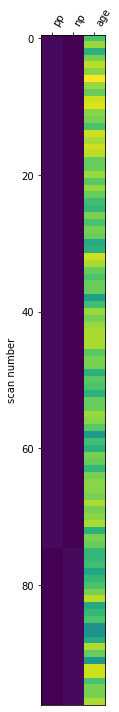

In [33]:
sec_lev_desi = pd.DataFrame({
    "pp": (data.loc[(na(),"T0",na()),:].group_str == "PP").astype(int),
    "np": (data.loc[(na(),"T0",na()),:].group_str == "NP").astype(int),
    "age": data.loc[(na(),"T0",na()),:].age
})

print(f"N = {data.loc[(na(),'T0',na()),:].shape[0]} subjects")
plot_design_matrix(sec_lev_desi, rescale=False)

#### Estimate

In [34]:
def run_2nd_level(data, contrast_par, contrast_nonpar, design=sec_lev_desi, 
                  vox_thresh=vox_thresh, cl_thresh=cl_thresh, cl_inference=cl_inference,
                  save_dir=wd, save_prefix="",
                  mask=mask, n_perm=n_perm, n_jobs=8, seed=42,
                  plot=True, cmap="cold_white_hot", title=""):
    # load data
    data = [load_img(d) for d in data]

    # fit 2nd level model
    sec_lev = SecondLevelModel(
        mask_img=mask,
        smoothing_fwhm=None, 
        n_jobs=n_jobs).fit(
            second_level_input=data,
            design_matrix=design,
        )

    # parametric
    sec_lev_par = sec_lev.compute_contrast(
        second_level_contrast=contrast_par,
        output_type="all")
    
    # non-parametric
    sec_lev_nonpar = non_parametric_inference(
        second_level_input=data,
        design_matrix=design,
        second_level_contrast=contrast_nonpar,
        mask=mask,
        model_intercept=True,
        n_perm=n_perm,
        two_sided_test=False,
        smoothing_fwhm=None,
        n_jobs=n_jobs,
        random_state=seed,
        threshold=vox_thresh
    )
    
    # extract and save results maps
    maps = {}
    maps["map_par_logp"] = math_img("-np.log10(i)", i=sec_lev_par["p_value"])
    maps["map_nonpar_logp"] = sec_lev_nonpar[f"logp_max_{cl_inference}"]
    cl_sig = (maps["map_nonpar_logp"].get_fdata() > cl_thresh).any()
    if cl_sig:
        maps["map_nonpar_bin"] = math_img(f"i > {cl_thresh}", i=maps["map_nonpar_logp"])
        maps["map_nonpar_idx"], _, cl_sizes = index_clusters_bin(maps["map_nonpar_bin"])
        print(f"{cl_sizes.shape[0]} significant cluster(s) detected.")
    else:
        print("No significant clusters detected.")
    for m in maps:
        maps[m].to_filename(join(save_dir, f"{save_prefix}{m}.nii.gz"))
    
    # plot con1
    if plot:
        gb = plot_glass_brain(
            maps["map_par_logp"], 
            display_mode = "lzry",
            colorbar=True, 
            cmap=cmap,
            title=title
        )
        if cl_sig:
            gb.add_contours(
                img=maps["map_nonpar_logp"], 
                levels=[cl_thresh], 
                colors="k", 
            )
            gb.add_overlay(
                img=maps["map_nonpar_idx"],
                cmap="tab10",
                alpha=0.8
            )
        plt.show()
    
    # return
    return maps

In [35]:
# iterate voxe-wise measures
sec_level_res = {}

for measure in ["falff", "lcor", "gcor"]:
    sec_level_res[measure] = {}
    
    # RERUN
    if rerun_sec_lev:
        # get data files
        vols = [load_img(d) for d in data.loc[(na(),"T0",na()), measure + "_path"].to_list()]
        
        # con1
        sec_level_res[measure]["con1"] = run_2nd_level(
            data=vols,
            contrast_par=np.array([1, -1, 0]),
            contrast_nonpar=np.array([1, 0, 0]),
            save_dir=join(wd, "results"),
            save_prefix=f"{measure}_con1_",
            cmap="cold_white_hot", 
            title=f"{measure}: PP > NP [-lg(p)]"
        )
        
        # con2
        sec_level_res[measure]["con2"] = run_2nd_level(
            data=vols,
            contrast_par=np.array([-1, 1, 0]),
            contrast_nonpar=np.array([0, 1, 0]),
            save_dir=join(wd, "results"),
            save_prefix=f"{measure}_con2_",
            cmap="cold_white_hot_r", 
            title=f"{measure}: PP < NP [-lg(p)]"
        )
    
    else:
        # NOT RERUN, JUST LOAD SAVED FILES
        for con in ["con1", "con2"]:
            sec_level_res[measure][con] = {}
            for file in glob(join(wd, "results", f"{measure}_{con}_*.nii.gz")):
                name = os.path.basename(file).replace(f"{measure}_{con}_", "").replace(".nii.gz", "")
                sec_level_res[measure][con][name] = load_img(file)

# show results dict
sec_level_res

{'falff': {'con1': {'map_nonpar_bin': <nibabel.nifti1.Nifti1Image at 0x7f93452a9130>,
   'map_par_logp': <nibabel.nifti1.Nifti1Image at 0x7f93452a2490>,
   'map_nonpar_logp': <nibabel.nifti1.Nifti1Image at 0x7f93452a2340>,
   'map_nonpar_idx': <nibabel.nifti1.Nifti1Image at 0x7f93452a6b80>},
  'con2': {'map_nonpar_logp': <nibabel.nifti1.Nifti1Image at 0x7f93452a6e20>,
   'map_par_logp': <nibabel.nifti1.Nifti1Image at 0x7f93008b8c40>,
   'map_nonpar_idx': <nibabel.nifti1.Nifti1Image at 0x7f93008b8e50>,
   'map_nonpar_bin': <nibabel.nifti1.Nifti1Image at 0x7f93452889d0>}},
 'lcor': {'con1': {'map_par_logp': <nibabel.nifti1.Nifti1Image at 0x7f9345288880>,
   'map_nonpar_logp': <nibabel.nifti1.Nifti1Image at 0x7f934528e3a0>},
  'con2': {'map_par_logp': <nibabel.nifti1.Nifti1Image at 0x7f934528e4c0>,
   'map_nonpar_logp': <nibabel.nifti1.Nifti1Image at 0x7f934528ecd0>,
   'map_nonpar_idx': <nibabel.nifti1.Nifti1Image at 0x7f9343552a30>,
   'map_nonpar_bin': <nibabel.nifti1.Nifti1Image at 0x

## Post-hoc MRI analyses

### Cluster statistics

In [36]:
cl_stat = list()
for measure, measure_name in zip(["falff", "lcor", "gcor"], ["fALFF", "LCOR", "GCOR"]):
    for con, con_name in zip(["con1", "con2"], ["PP > NP", "PP < NP"]):
        
        if "map_nonpar_bin" in sec_level_res[measure][con].keys():
            map_thresh = sec_level_res[measure][con]["map_nonpar_logp"]
        
            cl_stat_stat = get_clusters_table(
                map_thresh,
                cl_thresh
            )
            cl_stat_atlas = get_statmap_info(
                map_thresh,
                cluster_extent=1,
                voxel_thresh=cl_thresh
            )[0]
            cl_stat.append(
                pd.concat([
                    cl_stat_stat[["X","Y","Z","Peak Stat","Cluster Size (mm3)"]], 
                    cl_stat_atlas["aal"]
                ], axis="columns") \
                    .assign(Measure=measure_name, Contrast=con_name) \
                    .set_index(["Measure", "Contrast"], drop=True)
            )

cl_stat = pd.concat(cl_stat, axis="index")
cl_stat["Peak Stat"] = cl_stat["Peak Stat"].astype("float").round(2)
cl_stat[["X", "Y", "Z"]] = cl_stat[["X", "Y", "Z"]].astype(int)
cl_stat = cl_stat.rename(columns={
    "Peak Stat": "-lg(p)",
    "Cluster Size (mm3)": "Cluster size [mm^3]",
    "aal": "AAL region coverage"
})

cl_names = [
    "fALFF-PP>NP-rightPrecentral", "fALFF-PP>NP-leftMedTemp",
    "fALFF-PP<NP-rightPFC",
    "LCOR-PP<NP-leftIns", "LCOR-PP<NP-rightIns",
    "GCOR-PP<NP-leftPut", "GCOR-PP<NP-rightPut", 
]
cl_stat["Cluster name"] = [name.split("-")[2] for name in cl_names]
cl_stat = cl_stat.set_index("Cluster name", append=True)

cl_stat.to_csv(join(wd, "tables", "cluster_stat.csv"))
cl_stat.to_html(join(wd, "tables", "cluster_stat.html"))
cl_stat

/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/reporting/_get_clusters_table.py:103: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  warnings.warn(
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/reporting/_get_clusters_table.py:103: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  warnings.warn(


X   Y   Z  -lg(p)  Cluster size [mm^3]  \
Measure Contrast Cluster name                                               
fALFF   PP > NP  rightPrecentral  40 -20  60    1.43                 3672   
                 leftMedTemp     -29  10 -36    1.37                 3321   
        PP < NP  rightPFC         22  37  45    1.31                 2835   
LCOR    PP < NP  leftIns         -41 -17   9    2.23                11124   
                 rightIns         43  -2   6    1.44                 5481   
GCOR    PP < NP  leftPut         -26  -2   3    1.78                 5724   
                 rightPut         28  -5   3    1.60                 5373   

                                                                AAL region coverage  
Measure Contrast Cluster name                                                        
fALFF   PP > NP  rightPrecentral          72.06% Precentral_R; 22.79% Postcentral_R  
                 leftMedTemp      47.97% Temporal_Pole_Mid_L; 19.51% ParaHippoca...  
        PP < NP  rightPFC            80.95% Frontal_Sup_2_R; 14.29% Frontal_Mid_2_R  
LCOR    PP < NP  leftIns          36.89% Insula_L; 32.52% Rolandic_Oper_L; 9.95%...  
                 rightIns         57.64% Insula_R; 25.62% Rolandic_Oper_R; 9.85%...  
GCOR    PP < NP  leftPut          71.23% Putamen_L; 20.28% Pallidum_L; 8.02% no_...  
                 rightPut         63.32% Putamen_R; 16.08% Pallidum_R; 13.57% no...

### Data extraction

In [37]:
rerun_cl_extract = False

In [38]:
if rerun_cl_extract:
    # structural data
    vols_struct = [load_img(d) for d in data.gm_anat_path.to_list()]
    vbm_nona = ~data.vbm_path.isnull()
    vols_vbm = [load_img(d) for d in data.vbm_path[vbm_nona].to_list()]

    # VOXEL-WISE
    for measure in ["falff", "lcor", "gcor"]:
        print(measure)
        
        # image data
        vols_func = [load_img(d) for d in data[measure + "_path"].to_list()]
            
        for con in ["con1", "con2"]:
            
            # indexed thresholded image
            if "map_nonpar_idx" in sec_level_res[measure][con].keys():
                
                # masker
                masker = NiftiLabelsMasker(
                    labels_img=sec_level_res[measure][con]["map_nonpar_idx"],
                    standardize=False,
                )
                # extract functional and structural data
                temp_func = masker.fit_transform(vols_func)
                temp_struct = masker.fit_transform(vols_struct)
                temp_vbm = masker.fit_transform(vols_vbm)
                for cl in range(temp_func.shape[1]):
                    data[f"{measure}_{con}_cl{cl+1}"] = temp_func[:, cl]
                    data[f"gm_{measure}_{con}_cl{cl+1}"] = temp_struct[:, cl]    
                    data.loc[vbm_nona, f"vbm_{measure}_{con}_cl{cl+1}"] = temp_vbm[:, cl]    

    # SAVE    
    data.to_csv(join(wd, "pheno", "pprs_pheno_mri_proc_res.csv"))
    
else:
    data = pd.read_csv(join(wd, "pheno", "pprs_pheno_mri_proc_res.csv"))
    data = data.set_index(["idx_id", "idx_tp", "idx_group"])

#### Cluster/Network labels

In [39]:
cl_labs = [c for c in data.columns if c.startswith("falff_con") | c.startswith("lcor_con") | c.startswith("gcor_con")]
print(len(cl_labs), cl_labs)

cl_names = cl_names
print(len(cl_names), cl_names)

cl_iter = []
for lab, name in zip(cl_labs, cl_names):
    name = name.split("-")
    cl_iter.append((
        lab, 
        name[0], 
        name[1].replace(">", " > ").replace("<", " < "), 
        "" if lab.startswith("nbs") else name[2] 
    ))
print(len(cl_iter), cl_iter)

7 ['falff_con1_cl1', 'falff_con1_cl2', 'falff_con2_cl1', 'lcor_con2_cl1', 'lcor_con2_cl2', 'gcor_con2_cl1', 'gcor_con2_cl2']
7 ['fALFF-PP>NP-rightPrecentral', 'fALFF-PP>NP-leftMedTemp', 'fALFF-PP<NP-rightPFC', 'LCOR-PP<NP-leftIns', 'LCOR-PP<NP-rightIns', 'GCOR-PP<NP-leftPut', 'GCOR-PP<NP-rightPut']
7 [('falff_con1_cl1', 'fALFF', 'PP > NP', 'rightPrecentral'), ('falff_con1_cl2', 'fALFF', 'PP > NP', 'leftMedTemp'), ('falff_con2_cl1', 'fALFF', 'PP < NP', 'rightPFC'), ('lcor_con2_cl1', 'LCOR', 'PP < NP', 'leftIns'), ('lcor_con2_cl2', 'LCOR', 'PP < NP', 'rightIns'), ('gcor_con2_cl1', 'GCOR', 'PP < NP', 'leftPut'), ('gcor_con2_cl2', 'GCOR', 'PP < NP', 'rightPut')]


### MRI baseline sensitivity analyses

In [40]:
mri_bl_confounds = list()

for lab, measure, contrast, name in cl_iter:
            
    # get MRI data
    temp_mri = data.loc[(na(), "T0", na()), lab]

    # initiate save df
    temp_df = pd.DataFrame({
        "Measure": measure,
        "Contrast": contrast,
        "Cluster name": name
    }, index=range(1))
    
    # iterate confounds
    for confound, confound_name in zip(
        [["age"], ["age", "fwd_mean", "fwd_max"], ["age", f"gm_{lab}"], ["age", "edu"]],
        ["Age", "Age, FWD", "Age, GM", "Age, Education"],
    ):
        
        temp_conf = data.loc[(na(), "T0", na()), confound]
        temp_na = ~temp_conf.isna().any(1).values
        # regress confound from data
        temp_resid = residuals(x=temp_conf[temp_na].values, y=temp_mri[temp_na].values)       
        
        # calc statistics
        aov = ancova(
            data=data.loc[(na(), "T0", na()),:][temp_na],
            dv=lab,
            between="group",
            covar=confound
        )
        f, p, np2 = [aov.loc[aov.Source=="group", c].values[0] for c in ["F", "p-unc", "np2"]]
        df = temp_na.sum() - len(confound) - 1
        
        g = compute_effsize(
            x=temp_resid[data[data.tp=="T0"].loc[temp_na].group_str == "PP"],
            y=temp_resid[data[data.tp=="T0"].loc[temp_na].group_str == "NP"],
            paired=False,
            eftype="hedges"
        )

        # save
        temp_df[("ANCOVA: PP vs. NP: " + confound_name, "F")] = f.round(2)
        temp_df[("ANCOVA: PP vs. NP: " + confound_name, "df")] = int(df)
        temp_df[("ANCOVA: PP vs. NP: " + confound_name, "-lg(p)")] = -np.log10(p).round(3) #p.round(3) if p >= 0.001 else "< 0.001"
        temp_df[("ANCOVA: PP vs. NP: " + confound_name, "np2")] = np2.round(2)
        temp_df[("ANCOVA: PP vs. NP: " + confound_name, "g")] = g.round(2)
    
    # save
    temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
    mri_bl_confounds.append(temp_df)

mri_bl_confounds = pd.concat(mri_bl_confounds)
mri_bl_confounds.columns = pd.MultiIndex.from_tuples(mri_bl_confounds.columns)

mri_bl_confounds.to_csv(join(wd, "tables", "mri_baseline_stat.csv"))
mri_bl_confounds.to_html(join(wd, "tables", "mri_baseline_stat.html"))
mri_bl_confounds

ANCOVA: PP vs. NP: Age                   \
                                                      F  df -lg(p)   np2   
Measure Contrast Cluster name                                              
fALFF   PP > NP  rightPrecentral                  21.33  96  4.917  0.18   
                 leftMedTemp                      28.60  96  6.214  0.23   
        PP < NP  rightPFC                         36.77  96  7.571  0.28   
LCOR    PP < NP  leftIns                          32.94  96  6.947  0.26   
                 rightIns                         21.55  96  4.957  0.18   
GCOR    PP < NP  leftPut                          16.63  96  4.026  0.15   
                 rightPut                         18.01  96  4.292  0.16   

                                       ANCOVA: PP vs. NP: Age, FWD             \
                                     g                           F  df -lg(p)   
Measure Contrast Cluster name                                                   
fALFF   PP > NP  rightPrecentral  1.05                       20.61  94  4.774   
                 leftMedTemp      1.21                       26.69  94  5.867   
        PP < NP  rightPFC        -1.37                       32.84  94  6.911   
LCOR    PP < NP  leftIns         -1.30                       29.85  94  6.410   
                 rightIns        -1.06                       19.13  94  4.498   
GCOR    PP < NP  leftPut         -0.93                       18.60  94  4.396   
                 rightPut        -0.97                       21.01  94  4.848   

                                             ANCOVA: PP vs. NP: Age, GM      \
                                   np2     g                          F  df   
Measure Contrast Cluster name                                                 
fALFF   PP > NP  rightPrecentral  0.18  1.02                      19.56  95   
                 leftMedTemp      0.22  1.16                      22.99  95   
        PP < NP  rightPFC         0.26 -1.28                      22.98  95   
LCOR    PP < NP  leftIns          0.24 -1.23                      13.21  95   
                 rightIns         0.17 -0.99                       7.75  95   
GCOR    PP < NP  leftPut          0.17 -0.97                      17.11  95   
                 rightPut         0.18 -1.03                      18.39  95   

                                                     \
                                 -lg(p)   np2     g   
Measure Contrast Cluster name                         
fALFF   PP > NP  rightPrecentral  4.582  0.17  0.97   
                 leftMedTemp      5.215  0.20  1.03   
        PP < NP  rightPFC         5.214  0.20 -0.93   
LCOR    PP < NP  leftIns          3.342  0.12 -0.61   
                 rightIns         2.188  0.08 -0.52   
GCOR    PP < NP  leftPut          4.115  0.15 -0.94   
                 rightPut         4.360  0.16 -0.97   

                                 ANCOVA: PP vs. NP: Age, Education             \
                                                                 F  df -lg(p)   
Measure Contrast Cluster name                                                   
fALFF   PP > NP  rightPrecentral                             17.19  89  4.109   
                 leftMedTemp                                 25.78  89  5.674   
        PP < NP  rightPFC                                    27.62  89  5.992   
LCOR    PP < NP  leftIns                                     28.06  89  6.066   
                 rightIns                                    15.32  89  3.748   
GCOR    PP < NP  leftPut                                     10.45  89  2.763   
                 rightPut                                     9.92  89  2.652   

                                              
                                   np2     g  
Measure Contrast Cluster name                 
fALFF   PP > NP  rightPrecentral  0.16  1.00  
                 leftMedTemp      0.23  1.22  
        PP < NP  rightPFC         0.24 -1.27  
LCOR    PP < NP  leftIns  

## Longitudinal MRI analyses

#### Cross: PP vs NP each timepoint

In [41]:
mri_long_unpaired = list()
p_list = list()

for tp in tps:
    
    subs_PP_tp = data.loc[(subs_PP_long, tp, "PP")].ID.unique().tolist()
    
    temp_df2 = list()
    for lab, measure, contrast, name in cl_iter:
            
        temp = pd.concat([
            data.loc[(subs_PP_tp, tp, "PP"), :],
            data.loc[(subs_NP, "T0", "NP"), :]
        ])
            
        # calc statistics
        aov = ancova(
            data=temp,
            dv=lab,
            between="group",
            covar="age"
        )
        f, p, np2 = [aov.loc[aov.Source=="group", c].values[0] for c in ["F", "p-unc", "np2"]]
        df = len(subs_PP_tp + subs_NP) - 2
        p_list.append(p)
        
        temp_resid = residuals(
            temp.age, 
            temp[lab]
        )
        
        g = compute_effsize(
            x=temp_resid[temp.group_str == "PP"],
            y=temp_resid[temp.group_str == "NP"],
            paired=False,
            eftype="hedges"
        )
        
        # initiate save df
        temp_df = pd.DataFrame({
            "Measure": measure,
            "Contrast": contrast,
            "Cluster name": name,
            (f"ANCOVA: PP-{tp} vs. NP: Age", "F"): f.round(2),
            (f"ANCOVA: PP-{tp} vs. NP: Age", "df"): int(df),
            (f"ANCOVA: PP-{tp} vs. NP: Age", "-lg(p)"): -np.log10(p).round(3), 
            (f"ANCOVA: PP-{tp} vs. NP: Age", "np2"): np2.round(2),
            (f"ANCOVA: PP-{tp} vs. NP: Age", "g"): g.round(2)
        }, index=range(1))
        
        # save
        temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
        temp_df2.append(temp_df)
        
    temp_df2 = pd.concat(temp_df2)
    mri_long_unpaired.append(temp_df2)

# p correction
q_list = -np.log10(mc_correction(p_list)[0]).reshape(len(cl_names), len(tps), order="F").round(3)
for i, tp in enumerate(tps):
     mri_long_unpaired[i][(f"ANCOVA: PP-{tp} vs. NP: Age", "-lg(q)")] = q_list[:,i]
     mri_long_unpaired[i] = mri_long_unpaired[i].iloc[:,[0,1,2,5,3,4]]

mri_long_unpaired = pd.concat(mri_long_unpaired, axis="columns")
mri_long_unpaired.columns = pd.MultiIndex.from_tuples(mri_long_unpaired.columns)

mri_long_unpaired.to_csv(join(wd, "tables", "mri_longitudinal_unpaired_stat.csv"))
mri_long_unpaired.to_html(join(wd, "tables", "mri_longitudinal_unpaired_stat.html"))
mri_long_unpaired

ANCOVA: PP-T0 vs. NP: Age                    \
                                                         F  df -lg(p) -lg(q)   
Measure Contrast Cluster name                                                  
fALFF   PP > NP  rightPrecentral                     22.81  40  4.597  3.275   
                 leftMedTemp                         17.13  40  3.743  2.722   
        PP < NP  rightPFC                            14.57  40  3.327  2.482   
LCOR    PP < NP  leftIns                             12.81  40  3.026  2.306   
                 rightIns                            12.03  40  2.889  2.266   
GCOR    PP < NP  leftPut                              5.39  40  1.592  1.366   
                 rightPut                             8.02  40  2.137  1.755   

                                             ANCOVA: PP-T1 vs. NP: Age      \
                                   np2     g                         F  df   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral  0.37  1.21                     14.74  40   
                 leftMedTemp      0.31  1.07                      4.32  40   
        PP < NP  rightPFC         0.27 -0.99                     24.65  40   
LCOR    PP < NP  leftIns          0.25 -0.93                      8.96  40   
                 rightIns         0.24 -0.91                      6.71  40   
GCOR    PP < NP  leftPut          0.12 -0.62                      3.52  40   
                 rightPut         0.17 -0.75                      4.51  40   

                                                ... ANCOVA: PP-T4 vs. NP: Age  \
                                 -lg(p) -lg(q)  ...                    -lg(p)   
Measure Contrast Cluster name                   ...                             
fALFF   PP > NP  rightPrecentral  3.356  2.482  ...                     1.659   
                 leftMedTemp      1.354  1.178  ...                     2.364   
        PP < NP  rightPFC         4.855  3.275  ...                     4.095   
LCOR    PP < NP  leftIns          2.321  1.901  ...                     2.554   
                 rightIns         1.873  1.600  ...                     1.954   
GCOR    PP < NP  leftPut          1.168  1.022  ...                     0.017   
                 rightPut         1.396  1.205  ...                     0.038   

                                                    ANCOVA: PP-T5 vs. NP: Age  \
                                 -lg(q)   np2     g                         F   
Measure Contrast Cluster name                                                   
fALFF   PP > NP  rightPrecentral  1.416  0.13  0.65                     10.76   
                 leftMedTemp      1.917  0.20  0.82                      7.99   
        PP < NP  rightPFC         2.949  0.34 -1.15                     10.96   
LCOR    PP < NP  leftIns          2.076  0.21 -0.86                      3.02   
                 rightIns         1.609  0.16 -0.72                      3.56   
GCOR    PP < NP  leftPut          0.009  0.00  0.01                      0.30   
                 rightPut         0.009  0.00 -0.03                      0.05   

                                                                
                                  df -lg(p) -lg(q)   np2     g  
Measure Contrast Cluster name                                   
fALFF   PP > NP  rightPrecentral  38  2.645  2.135  0.23  0.88  
                 leftMedTemp      38  2.123  1.755  0.18  0.76  
        PP < NP  rightPFC         38  2.682  2.138  0.23 -0.88  
LCOR    PP < NP  leftIns          38  1.044  0.926  0.08 -0.48  
                 rightIns         38  1.174  1.022  0.09 -0.52  
GCOR    PP < NP  leftPut          38  0.233  0.178  0.01  0.15  
                 rightPut         38  0.085  0.041  0.00  0.06  

[7 rows x 36 columns]

### Cross: PP vs NP each timepoint controlled for GM

In [42]:
mri_long_unpaired_gm = list()
p_list = list()

for tp in tps:
    
    subs_PP_tp = data.loc[(subs_PP_long, tp, "PP")].ID.unique().tolist()
    
    temp_df2 = list()
    for lab, measure, contrast, name in cl_iter:
            
        temp = pd.concat([
            data.loc[(subs_PP_tp, tp, "PP"), :],
            data.loc[(subs_NP, "T0", "NP"), :]
        ])
            
        # calc statistics
        aov = ancova(
            data=temp,
            dv=lab,
            between="group",
            covar=["age", "gm_"+lab]
        )
        f, p, np2 = [aov.loc[aov.Source=="group", c].values[0] for c in ["F", "p-unc", "np2"]]
        df = len(subs_PP_tp + subs_NP) - 2
        p_list.append(p)
        
        temp_resid = residuals(
            temp[["age", "gm_"+lab]], 
            temp[lab]
        )
        
        g = compute_effsize(
            x=temp_resid[temp.group_str == "PP"],
            y=temp_resid[temp.group_str == "NP"],
            paired=False,
            eftype="hedges"
        )
        
        # initiate save df
        temp_df = pd.DataFrame({
            "Measure": measure,
            "Contrast": contrast,
            "Cluster name": name,
            (f"ANCOVA: PP-{tp} vs. NP: Age", "F"): f.round(2),
            (f"ANCOVA: PP-{tp} vs. NP: Age", "df"): int(df),
            (f"ANCOVA: PP-{tp} vs. NP: Age", "-lg(p)"): -np.log10(p).round(3), 
            (f"ANCOVA: PP-{tp} vs. NP: Age", "np2"): np2.round(2),
            (f"ANCOVA: PP-{tp} vs. NP: Age", "g"): g.round(2)
        }, index=range(1))
        
        # save
        temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
        temp_df2.append(temp_df)
        
    temp_df2 = pd.concat(temp_df2)
    mri_long_unpaired_gm.append(temp_df2)

# p correction
q_list = -np.log10(mc_correction(p_list)[0]).reshape(len(cl_names), len(tps), order="F").round(3)
for i, tp in enumerate(tps):
     mri_long_unpaired_gm[i][(f"ANCOVA: PP-{tp} vs. NP: Age", "-lg(q)")] = q_list[:,i]
     mri_long_unpaired_gm[i] = mri_long_unpaired_gm[i].iloc[:,[0,1,2,5,3,4]]

mri_long_unpaired_gm = pd.concat(mri_long_unpaired_gm, axis="columns")
mri_long_unpaired_gm.columns = pd.MultiIndex.from_tuples(mri_long_unpaired_gm.columns)

mri_long_unpaired_gm.to_csv(join(wd, "tables", "mri_longitudinal_unpaired_gm_stat.csv"))
mri_long_unpaired_gm.to_html(join(wd, "tables", "mri_longitudinal_unpaired_gm_stat.html"))
mri_long_unpaired_gm

ANCOVA: PP-T0 vs. NP: Age                    \
                                                         F  df -lg(p) -lg(q)   
Measure Contrast Cluster name                                                  
fALFF   PP > NP  rightPrecentral                     19.22  40  4.051  2.676   
                 leftMedTemp                         14.60  40  3.321  2.419   
        PP < NP  rightPFC                            10.74  40  2.649  1.962   
LCOR    PP < NP  leftIns                              2.04  40  0.793  0.646   
                 rightIns                             4.83  40  1.466  1.144   
GCOR    PP < NP  leftPut                              4.94  40  1.491  1.146   
                 rightPut                             7.89  40  2.107  1.598   

                                             ANCOVA: PP-T1 vs. NP: Age      \
                                   np2     g                         F  df   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral  0.34  1.02                     14.26  40   
                 leftMedTemp      0.28  0.90                      3.40  40   
        PP < NP  rightPFC         0.22 -0.70                     18.87  40   
LCOR    PP < NP  leftIns          0.05 -0.26                      1.94  40   
                 rightIns         0.11 -0.48                      2.77  40   
GCOR    PP < NP  leftPut          0.11 -0.60                      3.55  40   
                 rightPut         0.17 -0.75                      4.70  40   

                                                ... ANCOVA: PP-T4 vs. NP: Age  \
                                 -lg(p) -lg(q)  ...                    -lg(p)   
Measure Contrast Cluster name                   ...                             
fALFF   PP > NP  rightPrecentral  3.264  2.419  ...                     1.684   
                 leftMedTemp      1.136  0.928  ...                     2.631   
        PP < NP  rightPFC         3.998  2.676  ...                     3.390   
LCOR    PP < NP  leftIns          0.764  0.633  ...                     1.293   
                 rightIns         0.981  0.789  ...                     1.517   
GCOR    PP < NP  leftPut          1.174  0.948  ...                     0.018   
                 rightPut         1.438  1.137  ...                     0.066   

                                                    ANCOVA: PP-T5 vs. NP: Age  \
                                 -lg(q)   np2     g                         F   
Measure Contrast Cluster name                                                   
fALFF   PP > NP  rightPrecentral  1.265  0.14  0.66                     10.00   
                 leftMedTemp      1.962  0.22  0.83                      7.17   
        PP < NP  rightPFC         2.419  0.29 -0.95                     10.36   
LCOR    PP < NP  leftIns          1.012  0.10 -0.46                      0.47   
                 rightIns         1.149  0.12 -0.58                      1.27   
GCOR    PP < NP  leftPut          0.018  0.00  0.01                      0.28   
                 rightPut         0.034  0.00 -0.05                      0.05   

                                                                
                                  df -lg(p) -lg(q)   np2     g  
Measure Contrast Cluster name                                   
fALFF   PP > NP  rightPrecentral  38  2.498  1.916  0.22  0.83  
                 leftMedTemp      38  1.955  1.508  0.17  0.68  
        PP < NP  rightPFC         38  2.564  1.941  0.22 -0.81  
LCOR    PP < NP  leftIns          38  0.303  0.211  0.01 -0.16  
                 rightIns         38  0.572  0.454  0.03 -0.30  
GCOR    PP < NP  leftPut          38  0.220  0.153  0.01  0.15  
                 rightPut         38  0.084  0.040  0.00  0.06  

[7 rows x 36 columns]

### Long: LMM

In [43]:
mri_long_lmm = list()
p_values = list()

for lab, measure, contrast, name in cl_iter:
    print(lab)
    
    # longitudinal data, only PP, doesnt matter if all timepoints
    temp_mri_long = data.loc[(subs_PP_long, na(), "PP"), :]
    
    # calculate LMM and pairwise paired t tests
    lmm = smf.mixedlm(f"{lab} ~ weeks_postpartal", data=temp_mri_long, groups="ID").fit()
    lmm2 = smf.mixedlm(f"{lab} ~ weeks_postpartal + np.square(weeks_postpartal)", data=temp_mri_long, groups="ID").fit()
    p_values.append(lmm.pvalues[["weeks_postpartal"]].to_list() + lmm2.pvalues[["weeks_postpartal"]].to_list())

    temp_df = pd.DataFrame({
        "Measure": measure,
        "Contrast": contrast,
        "Cluster name": name,
        ("", "df"): f"({lmm.df_modelwc}, {lmm.df_resid})",
        ("Weeks PP", "converged"): lmm.converged,
        ("Weeks PP", "coef"): lmm.params["weeks_postpartal"].round(4),
        ("Weeks PP", "-lg(p)"): -np.log10(lmm.pvalues["weeks_postpartal"]).round(3),
        ("Weeks PP^2", "converged"): lmm2.converged,
        ("Weeks PP^2", "coef"): lmm2.params["np.square(weeks_postpartal)"].round(4),
        ("Weeks PP^2", "-lg(p)"): -np.log10(lmm2.pvalues["np.square(weeks_postpartal)"]).round(3),
    }, index=range(1))
    
    # save
    temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
    mri_long_lmm.append(temp_df)
        
mri_long_lmm = pd.concat(mri_long_lmm)
mri_long_lmm.columns = pd.MultiIndex.from_tuples(mri_long_lmm.columns)

p_values = np.array(p_values).flatten()
q_values = mc_correction(p_values)[0]
mri_long_lmm["Weeks PP", "-lg(q)"] = -np.log10(q_values[::2]).round(3)
mri_long_lmm["Weeks PP^2", "-lg(q)"] = -np.log10(q_values[1::2]).round(3)

mri_long_lmm = mri_long_lmm.iloc[:, [0, 1,2,3,-2, 4,5,6,-1]]

mri_long_lmm.to_csv(join(wd, "tables", "mri_longitudinal_lmm_stat.csv"))
mri_long_lmm.to_html(join(wd, "tables", "mri_longitudinal_lmm_stat.html"))
mri_long_lmm

falff_con1_cl1
falff_con1_cl2
falff_con2_cl1
lcor_con2_cl1
lcor_con2_cl2
gcor_con2_cl1
gcor_con2_cl2


Weeks PP                        \
                                        df converged    coef -lg(p) -lg(q)   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral  (3, 108)      True -0.0050  0.486  0.381   
                 leftMedTemp      (3, 108)      True -0.0016  0.197  0.165   
        PP < NP  rightPFC         (3, 108)      True  0.0053  0.906  0.605   
LCOR    PP < NP  leftIns          (3, 108)      True  0.0034  0.650  0.407   
                 rightIns         (3, 108)      True  0.0027  0.496  0.381   
GCOR    PP < NP  leftPut          (3, 108)      True  0.0216  3.207  2.538   
                 rightPut         (3, 108)      True  0.0203  3.561  2.644   

                                 Weeks PP^2                        
                                  converged    coef -lg(p) -lg(q)  
Measure Contrast Cluster name                                      
fALFF   PP > NP  rightPrecentral       True  0.0011  0.985  0.815  
                 leftMedTemp           True  0.0003  0.283  0.276  
        PP < NP  rightPFC              True  0.0002  0.233  0.033  
LCOR    PP < NP  leftIns               True -0.0007  1.188  1.020  
                 rightIns              True -0.0003  0.356  0.381  
GCOR    PP < NP  leftPut               True -0.0016  1.309  1.843  
                 rightPut              True -0.0018  2.083  2.644

### Long: LMM controlled for GM

In [44]:
mri_long_lmm_gm = list()
p_values = list()

for lab, measure, contrast, name in cl_iter:
    print(lab)
    
    # longitudinal data, only PP, doesnt matter if all timepoints
    temp_mri_long = data.loc[(subs_PP_long, na(), "PP"), :]
    
    # calculate LMM and pairwise paired t tests
    lmm = smf.mixedlm(f"{lab} ~ weeks_postpartal + gm_{lab}", data=temp_mri_long, groups="ID").fit()
    lmm2 = smf.mixedlm(f"{lab} ~ weeks_postpartal + np.square(weeks_postpartal) + gm_{lab}", data=temp_mri_long, groups="ID").fit()
    p_values.append(lmm.pvalues[["weeks_postpartal"]].to_list() + lmm2.pvalues[["weeks_postpartal"]].to_list())

    temp_df = pd.DataFrame({
        "Measure": measure,
        "Contrast": contrast,
        "Cluster name": name,
        ("", "df"): f"({lmm.df_modelwc}, {lmm.df_resid})",
        ("Weeks PP", "converged"): lmm.converged,
        ("Weeks PP", "coef"): lmm.params["weeks_postpartal"].round(4),
        ("Weeks PP", "-lg(p)"): -np.log10(lmm.pvalues["weeks_postpartal"]).round(3),
        ("Weeks PP^2", "converged"): lmm2.converged,
        ("Weeks PP^2", "coef"): lmm2.params["np.square(weeks_postpartal)"].round(4),
        ("Weeks PP^2", "-lg(p)"): -np.log10(lmm2.pvalues["np.square(weeks_postpartal)"]).round(3),
    }, index=range(1))
    
    # save
    temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
    mri_long_lmm_gm.append(temp_df)
        
mri_long_lmm_gm = pd.concat(mri_long_lmm_gm)
mri_long_lmm_gm.columns = pd.MultiIndex.from_tuples(mri_long_lmm_gm.columns)

p_values = np.array(p_values).flatten()
q_values = -np.log10(mc_correction(p_values)[0])
mri_long_lmm_gm["Weeks PP", "-lg(q)"] = q_values[::2].round(3)
mri_long_lmm_gm["Weeks PP^2", "-lg(q)"] = q_values[1::2].round(3)

mri_long_lmm_gm = mri_long_lmm_gm.iloc[:, [0, 1,2,3,-2, 4,5,6,-1]]

mri_long_lmm_gm.to_csv(join(wd, "tables", "mri_longitudinal_lmm_gm_stat.csv"))
mri_long_lmm_gm.to_html(join(wd, "tables", "mri_longitudinal_lmm_gm_stat.html"))
mri_long_lmm_gm

falff_con1_cl1
falff_con1_cl2
falff_con2_cl1
lcor_con2_cl1
lcor_con2_cl2
gcor_con2_cl1
gcor_con2_cl2


Weeks PP                        \
                                        df converged    coef -lg(p) -lg(q)   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral  (4, 107)      True -0.0062  0.632  0.389   
                 leftMedTemp      (4, 107)      True -0.0017  0.208  0.141   
        PP < NP  rightPFC         (4, 107)      True  0.0047  0.698  0.389   
LCOR    PP < NP  leftIns          (4, 107)      True  0.0004  0.041  0.041   
                 rightIns         (4, 107)      True  0.0016  0.243  0.141   
GCOR    PP < NP  leftPut          (4, 107)      True  0.0211  3.029  2.360   
                 rightPut         (4, 107)      True  0.0208  3.752  2.606   

                                 Weeks PP^2                        
                                  converged    coef -lg(p) -lg(q)  
Measure Contrast Cluster name                                      
fALFF   PP > NP  rightPrecentral       True  0.0013  1.288  1.115  
                 leftMedTemp           True  0.0003  0.301  0.173  
        PP < NP  rightPFC              True  0.0003  0.306  0.082  
LCOR    PP < NP  leftIns               True -0.0005  0.687  0.389  
                 rightIns              True -0.0002  0.222  0.149  
GCOR    PP < NP  leftPut               True -0.0018  1.531  2.075  
                 rightPut              True -0.0018  1.890  2.427

### Long: PP vs PP each timepoint

In [45]:
mri_long_paired = list()
p_list = list()

for lab, measure, contrast, name in cl_iter:
    print(lab)
    
    # longitudinal data, only PP, doesnt matter if all timepoints
    temp_mri_long = data.loc[(subs_PP_long, na(), "PP"), :].copy()
    
    temp_df = pd.DataFrame({
        "Measure": measure,
        "Contrast": contrast,
        "Cluster name": name,
    }, index=range(1))
    
    ph = pairwise_tests(
        data=temp_mri_long,
        dv=lab,
        within="tp",
        subject="ID",
        padjust="fdr_bh",
        #alternative="less" if contrast=="PP < NP" else "greater"
    )
                
    # calculate single T-Tests PP vs PP
    # iterate timepoints
    for tp in ph.A.unique():
        for tp_comp in ph.loc[ph.A==tp, "B"].unique():
            
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "T")] = ph.loc[(ph.A==tp) & (ph.B==tp_comp), "T"].values[0].round(2)
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "-lg(p)")] = -np.log10(ph.loc[(ph.A==tp) & (ph.B==tp_comp), "p-unc"].values[0]).round(3)
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "-lg(q)")] = -np.log10(ph.loc[(ph.A==tp) & (ph.B==tp_comp), "p-corr"].values[0]).round(3)
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "g")] = ph.loc[(ph.A==tp) & (ph.B==tp_comp), "hedges"].values[0].round(2)
            
    # save
    temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
    mri_long_paired.append(temp_df)
        
mri_long_paired = pd.concat(mri_long_paired)
mri_long_paired.columns = pd.MultiIndex.from_tuples(mri_long_paired.columns)

mri_long_paired.to_csv(join(wd, "tables", "mri_longitudinal_paired_stat.csv"))
mri_long_paired.to_html(join(wd, "tables", "mri_longitudinal_paired_stat.html"))
mri_long_paired

falff_con1_cl1
falff_con1_cl2
falff_con2_cl1
lcor_con2_cl1
lcor_con2_cl2
gcor_con2_cl1
gcor_con2_cl2


T-test: T0 vs. T1                      \
                                                 T -lg(p) -lg(q)     g   
Measure Contrast Cluster name                                            
fALFF   PP > NP  rightPrecentral              1.24  0.628  0.104  0.38   
                 leftMedTemp                  1.54  0.838  0.347  0.44   
        PP < NP  rightPFC                    -0.15  0.053  0.023 -0.04   
LCOR    PP < NP  leftIns                     -0.09  0.033  0.033 -0.02   
                 rightIns                    -1.16  0.577  0.023 -0.27   
GCOR    PP < NP  leftPut                     -0.98  0.463  0.255 -0.29   
                 rightPut                    -1.47  0.788  0.564 -0.38   

                                 T-test: T0 vs. T2                      \
                                                 T -lg(p) -lg(q)     g   
Measure Contrast Cluster name                                            
fALFF   PP > NP  rightPrecentral              0.31  0.118  0.054  0.09   
                 leftMedTemp                  2.37  1.497  0.417  0.61   
        PP < NP  rightPFC                    -1.03  0.498  0.118 -0.36   
LCOR    PP < NP  leftIns                     -1.91  1.125  0.464 -0.57   
                 rightIns                    -1.26  0.645  0.023 -0.32   
GCOR    PP < NP  leftPut                     -1.45  0.773  0.442 -0.39   
                 rightPut                    -2.19  1.350  0.776 -0.50   

                                 T-test: T0 vs. T3         ...  \
                                                 T -lg(p)  ...   
Measure Contrast Cluster name                              ...   
fALFF   PP > NP  rightPrecentral              0.95  0.446  ...   
                 leftMedTemp                  1.30  0.673  ...   
        PP < NP  rightPFC                    -1.16  0.581  ...   
LCOR    PP < NP  leftIns                     -1.50  0.809  ...   
                 rightIns                    -0.67  0.292  ...   
GCOR    PP < NP  leftPut                     -2.05  1.235  ...   
                 rightPut                    -2.57  1.670  ...   

                                 T-test: T3 vs. T4       T-test: T3 vs. T5  \
                                            -lg(q)     g                 T   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral             0.104  0.24             -0.18   
                 leftMedTemp                 0.193 -0.23              0.12   
        PP < NP  rightPFC                    0.023  0.07             -0.87   
LCOR    PP < NP  leftIns                     0.351  0.33              0.28   
                 rightIns                    0.023 -0.06             -0.54   
GCOR    PP < NP  leftPut                     0.036 -0.04             -0.90   
                 rightPut                    0.019 -0.02             -0.27   

                                                     T-test: T4 vs. T5         \
                                 -lg(p) -lg(q)     g                 T -lg(p)   
Measure Contrast Cluster name                                                   
fALFF   PP > NP  rightPrecentral  0.064  0.034 -0.05             -1.57  0.862   
                 leftMedTemp      0.043  0.010  0.03              1.54  0.844   
        PP < NP  rightPFC         0.398  0.118 -0.21             -0.95  0.450   
LCOR    PP < NP  leftIns          0.108  0.078  0.07             -1.14  0.563   
                 rightIns         0.224  0.023 -0.14             -0.19  0.070   
GCOR    PP < NP  leftPut          0.417  0.255 -0.18             -0.57  0.240   
                 rightPut         0.103  0.041 -0.06             -0.13  0.045   

                                               
                                 -lg(q)     g  
Measure Contrast Cluster name                  
fALFF   PP > NP  rightPrecentral  0.136 -0.38  
                 leftMedTemp      0.347  0.28  
        PP < NP  rightPFC         0.118 -0.29  
LCOR    PP

### Long: PP vs PP each timepoint controlled for GM

In [46]:
mri_long_paired_gm = list()
p_list = list()

for lab, measure, contrast, name in cl_iter:
    print(lab)
    
    # longitudinal data, only PP, doesnt matter if all timepoints
    temp_mri_long = data.loc[(subs_PP_long, na(), "PP"), :].copy()
    
    # regress gm
    temp_mri_long[lab] = residuals(temp_mri_long["gm_"+lab], temp_mri_long[lab])
    
    temp_df = pd.DataFrame({
        "Measure": measure,
        "Contrast": contrast,
        "Cluster name": name,
    }, index=range(1))
    
    ph = pairwise_tests(
        data=temp_mri_long,
        dv=lab,
        within="tp",
        subject="ID",
        padjust="fdr_bh",
        #alternative="less" if contrast=="PP < NP" else "greater"
    )
                
    # calculate single T-Tests PP vs PP
    # iterate timepoints
    for tp in ph.A.unique():
        for tp_comp in ph.loc[ph.A==tp, "B"].unique():
            
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "T")] = ph.loc[(ph.A==tp) & (ph.B==tp_comp), "T"].values[0].round(2)
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "-lg(p)")] = -np.log10(ph.loc[(ph.A==tp) & (ph.B==tp_comp), "p-unc"].values[0]).round(3)
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "-lg(q)")] = -np.log10(ph.loc[(ph.A==tp) & (ph.B==tp_comp), "p-corr"].values[0]).round(3)
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "g")] = ph.loc[(ph.A==tp) & (ph.B==tp_comp), "hedges"].values[0].round(2)
            
    # save
    temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
    mri_long_paired_gm.append(temp_df)
        
mri_long_paired_gm = pd.concat(mri_long_paired_gm)
mri_long_paired_gm.columns = pd.MultiIndex.from_tuples(mri_long_paired_gm.columns)

mri_long_paired_gm.to_csv(join(wd, "tables", "mri_longitudinal_paired_gm_stat.csv"))
mri_long_paired_gm.to_html(join(wd, "tables", "mri_longitudinal_paired_gm_stat.html"))
mri_long_paired_gm

falff_con1_cl1
falff_con1_cl2
falff_con2_cl1
lcor_con2_cl1
lcor_con2_cl2
gcor_con2_cl1
gcor_con2_cl2


T-test: T0 vs. T1                      \
                                                 T -lg(p) -lg(q)     g   
Measure Contrast Cluster name                                            
fALFF   PP > NP  rightPrecentral              1.48  0.798  0.321  0.45   
                 leftMedTemp                  1.40  0.742  0.309  0.43   
        PP < NP  rightPFC                    -0.06  0.020  0.011 -0.02   
LCOR    PP < NP  leftIns                      0.62  0.264  0.167  0.17   
                 rightIns                    -0.79  0.353  0.016 -0.20   
GCOR    PP < NP  leftPut                     -1.04  0.502  0.280 -0.30   
                 rightPut                    -1.47  0.788  0.564 -0.38   

                                 T-test: T0 vs. T2                      \
                                                 T -lg(p) -lg(q)     g   
Measure Contrast Cluster name                                            
fALFF   PP > NP  rightPrecentral              0.60  0.253  0.118  0.17   
                 leftMedTemp                  2.28  1.425  0.362  0.63   
        PP < NP  rightPFC                    -0.90  0.418  0.090 -0.31   
LCOR    PP < NP  leftIns                     -1.17  0.584  0.198 -0.36   
                 rightIns                    -0.76  0.339  0.016 -0.21   
GCOR    PP < NP  leftPut                     -1.69  0.951  0.474 -0.46   
                 rightPut                    -2.19  1.350  0.776 -0.50   

                                 T-test: T0 vs. T3         ...  \
                                                 T -lg(p)  ...   
Measure Contrast Cluster name                              ...   
fALFF   PP > NP  rightPrecentral              1.21  0.613  ...   
                 leftMedTemp                  1.43  0.763  ...   
        PP < NP  rightPFC                    -0.85  0.388  ...   
LCOR    PP < NP  leftIns                     -0.69  0.299  ...   
                 rightIns                    -0.15  0.055  ...   
GCOR    PP < NP  leftPut                     -2.15  1.320  ...   
                 rightPut                    -2.57  1.670  ...   

                                 T-test: T3 vs. T4       T-test: T3 vs. T5  \
                                            -lg(q)     g                 T   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral             0.148  0.26             -0.17   
                 leftMedTemp                 0.235 -0.26              0.02   
        PP < NP  rightPFC                    0.020  0.07             -0.80   
LCOR    PP < NP  leftIns                     0.198  0.37              0.62   
                 rightIns                    0.016 -0.04             -0.35   
GCOR    PP < NP  leftPut                     0.031 -0.03             -0.66   
                 rightPut                    0.019 -0.02             -0.27   

                                                     T-test: T4 vs. T5         \
                                 -lg(p) -lg(q)     g                 T -lg(p)   
Measure Contrast Cluster name                                                   
fALFF   PP > NP  rightPrecentral  0.063  0.033 -0.05             -1.68  0.947   
                 leftMedTemp      0.006  0.006  0.00              1.49  0.807   
        PP < NP  rightPFC         0.363  0.090 -0.19             -0.92  0.431   
LCOR    PP < NP  leftIns          0.266  0.167  0.19             -0.73  0.323   
                 rightIns         0.138  0.016 -0.11             -0.13  0.045   
GCOR    PP < NP  leftPut          0.286  0.189 -0.13             -0.40  0.157   
                 rightPut         0.103  0.041 -0.06             -0.13  0.045   

                                               
                                 -lg(q)     g  
Measure Contrast Cluster name                  
fALFF   PP > NP  rightPrecentral  0.321 -0.39  
                 leftMedTemp      0.309  0.28  
        PP < NP  rightPFC         0.090 -0.29  
LCOR    PP

## Spatial correlation analyses

In [47]:
reload_aba = False
rerun_spc = False

### Get data

#### Get ABA data

In [48]:
if reload_aba:
    # abagen parcellation info
    parc_info_aba = parc_info[["idx", "label"]].rename(columns={"idx":"id"})
    parc_info_aba["hemisphere"] = [l.split("_")[0][0] for l in parc_info_aba.label]
    parc_info_aba["structure"] = ["cortex"]*100 + ["subcortex/brainstem"]*16

    # get ABA data using abagen
    aba_data, aba_report = get_expression_data(
        atlas=parc, atlas_info=parc_info_aba, n_proc=6, lr_mirror="bidirectional", 
        return_donors=False, sim_threshold=None, ibf_threshold=0,
        return_report=True)
    print(aba_data.shape)   
    
    # save report
    with open(join(wd, "templates", "aba_report.md"), "w") as f:
        f.write(aba_report)
    
    # get progesterone data
    pred_aba = aba_data[["PGR", "ESR1", "ESR2", "NR3C1", "NR3C2", "OXTR"]]
    pred_aba.index = pd.Index(parc_labels, name="labels")
    pred_aba.to_csv(join(wd, "templates", "aba_genes.csv"))

else:
    pred_aba = pd.read_csv(join(wd, "templates", "aba_genes.csv"), index_col=0)   
    
pred_aba

PGR      ESR1      ESR2     NR3C1     NR3C2      OXTR
labels                                                              
LH_Vis_1  0.222498  0.553936  0.439263  0.383016  0.367968  0.639385
LH_Vis_2  0.415130  0.537360  0.388303  0.657954  0.661821  0.335857
LH_Vis_3  0.413889  0.595157  0.392483  0.791534  0.716783  0.326252
LH_Vis_4  0.401333  0.447704  0.368531  0.727932  0.756191  0.315482
LH_Vis_5  0.516106  0.502707  0.359334  0.772911  0.738882  0.276631
...            ...       ...       ...       ...       ...       ...
LH_aTHA   0.439866  0.588247  0.325171  0.512618  0.247892  0.672045
LH_NAc    0.502808  0.443996  0.639710  0.141942  0.347472  0.895523
LH_GP     0.713894  0.495792  0.318059  0.212072  0.237406  0.940447
LH_PUT    0.584044  0.599100  0.351744  0.193175  0.262752  0.781266
LH_CAU    0.589592  0.635362  0.423659  0.161478  0.329627  0.727534

[116 rows x 6 columns]

#### Get PET data

In [49]:
parcellater = NiftiLabelsMasker(parc, parc_labels)
pred_pet = pd.DataFrame({
    "GABAa": parcellater.fit_transform(join(wd, "templates", "GABAa-flumazenil-10-kaulen2022.nii.gz"))[0],
    "mGluR5": parcellater.fit_transform(join(wd, "templates", "mGluR5-abp688-73-smart2019.nii.gz"))[0], 
}, index=pd.Index(parc_labels, name="labels"))

pred_pet

GABAa    mGluR5
labels                      
LH_Vis_1  4.031084  0.682609
LH_Vis_2  4.621154  0.603923
LH_Vis_3  4.881261  0.685738
LH_Vis_4  4.375549  0.441224
LH_Vis_5  5.459651  0.583395
...            ...       ...
LH_aTHA   2.387313  0.447596
LH_NAc    3.365715  0.973463
LH_GP     1.249059  0.262738
LH_PUT    2.343880  0.795402
LH_CAU    1.593403  0.719287

[116 rows x 2 columns]

### Perform spatial correlations

In [50]:
metrics = ["fALFF", "LCOR", "GCOR"]

if rerun_spc:
    
    # run
    res_jsp = dict()
    for m in metrics:
        res_jsp[m] = dict()
        print(m)

        jsp = JuSpyce(
            x=pd.concat([pred_aba, pred_pet], axis=1).T,
            y=data[m.lower() + "_path"].to_list(),
            data_space="mni152",
            parcellation=parc,
            parcellation_space="mni152",
            parcellation_labels=parc_info.label.to_list(),
            y_labels=data.index,
            standardize="x",
            drop_nan=False,
            n_proc=8
        ).fit(verbose=False)

        for tp in tps:
            res_jsp[m][tp] = dict()
            print(tp)
            
            groups = (data.group.replace({0:2}) * ((data.tp == tp) | (data.group_str == "NP"))).replace({0:np.nan})
            
            jsp.compare(comparison="z(A,B)", groups=groups, verbose=False)
            jsp.predict(comparison="z(A,B)", method="spearman", r_to_z=True, verbose=False)
            jsp.predict(comparison="z(A,B)", method="mlr", adjust_r2=True, verbose=False)
            jsp.permute_groups(
                comparison="z(A,B)",
                groups=groups,
                method="spearman",
                p_from_average_y="mean",
                r_to_z=True,
                n_perm=10000,
                seed=42,
                verbose=False
            )

            res_jsp[m][tp]["zr"] = jsp.predictions["z(A,B)-spearman"]
            res_jsp[m][tp]["zrp"] = jsp.p_comparisons["z(A,B)-spearman-norm"]
            res_jsp[m][tp]["r2"] = jsp.predictions["z(A,B)-mlr_full_r2"]    
            
    # collect results
    spc_zr, spc_r2, spc_sig = [], [], []
    for m in metrics:
        spc_zr.append(pd.concat([res_jsp[m][tp]["zr"] for tp in tps]).assign(idx_metric=m).set_index("idx_metric", append=True))
        spc_sig.append(pd.concat([res_jsp[m][tp]["zrp"] for tp in tps]).assign(idx_metric=m).set_index("idx_metric", append=True))
        spc_r2.append(pd.concat([res_jsp[m][tp]["r2"] for tp in tps]).assign(idx_metric=m).set_index("idx_metric", append=True))
    spc_zr, spc_r2, spc_sig = pd.concat(spc_zr), pd.concat(spc_r2), pd.concat(spc_sig)
    spc_sig.index = pd.MultiIndex.from_tuples([(m, tp) for m in metrics for tp in tps])
    
    # save
    spc_zr.to_csv(join(wd, "results", "spc_zr.csv"))
    spc_sig.to_csv(join(wd, "results", "spc_zr_sig.csv"))
    spc_r2.to_csv(join(wd, "results", "spc_r2.csv"))
    
else:
    
    # load
    spc_zr = pd.read_csv(join(wd, "results", "spc_zr.csv"), index_col=[0,1,2,3])
    spc_sig = pd.read_csv(join(wd, "results", "spc_zr_sig.csv"), index_col=[0,1])
    spc_r2 = pd.read_csv(join(wd, "results", "spc_r2.csv"), index_col=[0,1,2,3])
    
    
# merge and print overview results
data_spc = data
for m in metrics:
    data_spc = data_spc.merge(
        spc_zr.loc[na(),na(),na(), m].rename(columns=dict(zip(spc_zr.columns, [m+"_"+c for c in spc_zr.columns]))), 
        left_index=True, 
        right_index=True
    )

print("Average Spearman colocalization")
display(spc_zr.groupby(["idx_metric", "idx_tp"], sort=False).mean().loc[(na(), "T0"),:].round(2))
print("Associated group-permutation p-values")
display(spc_sig.loc[(na(), "T0"),:])
print("Average R2")
display(spc_r2.groupby(["idx_metric", "idx_tp"], sort=False).mean().loc[(na(), "T0"),:].round(2))

Average Spearman colocalization


PGR  ESR1  ESR2  NR3C1  NR3C2  OXTR  GABAa  mGluR5
idx_metric idx_tp                                                     
fALFF      T0      0.09  0.07  0.01  -0.03  -0.00 -0.01  -0.05   -0.18
LCOR       T0      0.04  0.08 -0.01   0.08   0.08 -0.10   0.02   -0.12
GCOR       T0     -0.08 -0.04  0.03   0.15   0.18 -0.19   0.10    0.04

Associated group-permutation p-values


PGR      ESR1      ESR2     NR3C1     NR3C2      OXTR  \
fALFF T0  0.004253  0.028599  0.849298  0.409073  0.798893  0.973311   
LCOR  T0  0.180687  0.019565  0.562953  0.100821  0.048343  0.061053   
GCOR  T0  0.008608  0.126979  0.159154  0.014347  0.002777  0.003556   

             GABAa    mGluR5  
fALFF T0  0.191247  0.000047  
LCOR  T0  0.645090  0.027698  
GCOR  T0  0.024879  0.329048

Average R2


mlr_full_r2
idx_metric idx_tp             
fALFF      T0             0.17
LCOR       T0             0.13
GCOR       T0             0.18

### SPC statistics

#### Cross: PP-NP each timepoint

In [51]:
spc_cross = list()

for tp in tps:
    temp = dict()
    
    for m in metrics:
        for receptor in spc_zr.columns:
                
            temp[(m, receptor)] = pd.DataFrame({
                (tp, "rho (mean)"): spc_zr.groupby(["idx_metric", "idx_tp"]).mean().loc[(m, tp),receptor].round(2),
                (tp, "rho (sd)"): spc_zr.groupby(["idx_metric", "idx_tp"]).std().loc[(m, tp),receptor].round(2),
                (tp, "p"): spc_sig.loc[(m, tp), receptor]
            }, index=range(1))    

    spc_cross.append(pd.concat(temp))    

spc_cross = pd.concat(spc_cross, axis=1)
spc_cross.index = spc_cross.index.droplevel(2)
spc_cross.index.names = ["Measure", "Receptor"]

spc_cross[("T0", "q")] = mc_correction(spc_cross[("T0", "p")])[0].round(4)
spc_cross.loc[spc_cross["T0", "q"] > 0.05, (tps[1:],na())] = np.nan

spc_cross.loc[spc_cross["T0", "q"] <= 0.05, (tps[1:],"p")]
temp = mc_correction(spc_cross.loc[spc_cross["T0", "q"] <= 0.05, (tps[1:],"p")])[0].round(3)
for tp in tps[1:]:
    spc_cross.loc[spc_cross["T0", "q"] <= 0.05, (tp, "q")] = temp[(tp, "p")]

spc_cross = spc_cross[[(tp, c) for tp in tps for c in ["rho (mean)", "rho (sd)", "p", "q"]]]

spc_cross.to_csv(join(wd, "tables", "spc_cross_stat.csv"))
spc_cross.to_html(join(wd, "tables", "spc_cross_stat.html"))
spc_cross 

T0                                    T1           \
                 rho (mean) rho (sd)         p       q rho (mean) rho (sd)   
Measure Receptor                                                             
fALFF   PGR            0.09     0.12  0.004253  0.0255       0.06     0.08   
        ESR1           0.07     0.13  0.028599  0.0686        NaN      NaN   
        ESR2           0.01     0.10  0.849298  0.8862        NaN      NaN   
        NR3C1         -0.03     0.24  0.409073  0.5167        NaN      NaN   
        NR3C2         -0.00     0.23  0.798893  0.8715        NaN      NaN   
        OXTR          -0.01     0.24  0.973311  0.9733        NaN      NaN   
        GABAa         -0.05     0.19  0.191247  0.2700        NaN      NaN   
        mGluR5        -0.18     0.19  0.000047  0.0011      -0.24     0.19   
LCOR    PGR            0.04     0.13  0.180687  0.2700        NaN      NaN   
        ESR1           0.08     0.13  0.019565  0.0671        NaN      NaN   
        ESR2          -0.01     0.10  0.562953  0.6755        NaN      NaN   
        NR3C1          0.08     0.19  0.100821  0.1861        NaN      NaN   
        NR3C2          0.08     0.17  0.048343  0.1055        NaN      NaN   
        OXTR          -0.10     0.22  0.061053  0.1221        NaN      NaN   
        GABAa          0.02     0.14  0.645090  0.7372        NaN      NaN   
        mGluR5        -0.12     0.25  0.027698  0.0686        NaN      NaN   
GCOR    PGR           -0.08     0.12  0.008608  0.0413      -0.06     0.13   
        ESR1          -0.04     0.12  0.126979  0.2177        NaN      NaN   
        ESR2           0.03     0.10  0.159154  0.2546        NaN      NaN   
        NR3C1          0.15     0.23  0.014347  0.0574        NaN      NaN   
        NR3C2          0.18     0.25  0.002777  0.0255       0.14     0.23   
        OXTR          -0.19     0.25  0.003556  0.0255      -0.16     0.27   
        GABAa          0.10     0.18  0.024879  0.0686        NaN      NaN   
        mGluR5         0.04     0.17  0.329048  0.4387        NaN      NaN   

                                          T2           ...        T3         \
                         p      q rho (mean) rho (sd)  ...         p      q   
Measure Receptor                                       ...                    
fALFF   PGR       0.134094  0.223       0.09     0.10  ...  0.095463  0.199   
        ESR1           NaN    NaN        NaN      NaN  ...       NaN    NaN   
        ESR2           NaN    NaN        NaN      NaN  ...       NaN    NaN   
        NR3C1          NaN    NaN        NaN      NaN  ...       NaN    NaN   
        NR3C2          NaN    NaN        NaN      NaN  ...       NaN    NaN   
        OXTR           NaN    NaN        NaN      NaN  ...       NaN    NaN   
        GABAa          NaN    NaN        NaN      NaN  ...       NaN    NaN   
        mGluR5    0.000050  0.001      -0.27     0.13  ...  0.004006  0.020   
LCOR    PGR            NaN    NaN        NaN      NaN  ...       NaN    NaN   
        ESR1           NaN    NaN        NaN      NaN  ...       NaN    NaN   
        ESR2           NaN    NaN        NaN      NaN  ...       NaN    NaN   
        NR3C1          NaN    NaN        NaN      NaN  ...       NaN    NaN   
        NR3C2          NaN    NaN        NaN      NaN  ...       NaN    NaN   
        OXTR           NaN    NaN        NaN      NaN  ...       NaN    NaN   
        GABAa          NaN    NaN        NaN      NaN  ...       NaN    NaN   
        mGluR5         NaN    NaN        NaN      NaN  ...       NaN    NaN   
GCOR    PGR       0.133533  0.223      -0.09     0.09  ...  0.736746  0.836   
        ESR1           NaN    NaN        NaN      NaN  ...       NaN    NaN   
        ESR2           NaN    NaN        NaN      NaN  ...       NaN    NaN   
        NR3C1          NaN    NaN        NaN      NaN  ...       NaN    NaN   
        NR3C2     0.081415  0.185       0.10     0.22  ...  0.935812  0.936   
        OXTR      0.07

#### Long: LMM

In [52]:
spc_long = dict()

for m in metrics:
    for receptor in spc_zr.columns:
        if spc_cross.loc[(m, receptor), ("T0", "q")] < 0.05:
            print(m, receptor)
        
            temp = data_spc.loc[(subs_PP_long, na(), "PP"), [f"{m}_{receptor}", "weeks_postpartal", "ID"]].dropna()
            lmm = smf.mixedlm(f"{m}_{receptor} ~ weeks_postpartal", data=temp, groups="ID").fit()
            lmm2 = smf.mixedlm(f"{m}_{receptor} ~ weeks_postpartal + np.square(weeks_postpartal)", data=temp, groups="ID").fit()
        
            spc_long[(m, receptor)] = pd.DataFrame({
                ("", "df"): f"({lmm.df_modelwc}, {lmm.df_resid})",
                ("Weeks PP", "converged"): lmm.converged,
                ("Weeks PP", "coef"): lmm.params["weeks_postpartal"].round(4),
                ("Weeks PP", "p"): lmm.pvalues["weeks_postpartal"],
                ("Weeks PP^2", "converged"): lmm2.converged,
                ("Weeks PP^2", "coef"): lmm2.params["np.square(weeks_postpartal)"].round(4),
                ("Weeks PP^2", "p"): lmm2.pvalues["np.square(weeks_postpartal)"],
            }, index=range(1))
        
spc_long = pd.concat(spc_long)
spc_long.index = spc_long.index.droplevel(2)
spc_long.index.names = ["Measure", "Receptor"]


temp = mc_correction(spc_long.loc[:, (["Weeks PP", "Weeks PP^2"], "p")])[0].round(3)
spc_long[("Weeks PP", "q")] = temp[("Weeks PP", "p")]
spc_long[("Weeks PP^2", "q")] = temp[("Weeks PP^2", "p")]

spc_long[("Weeks PP", "p")] = spc_long[("Weeks PP", "p")].round(3)
spc_long[("Weeks PP^2", "p")] = spc_long[("Weeks PP^2", "p")].round(3)

spc_long = spc_long[[("", "df")] + [(t, c) for t in ["Weeks PP", "Weeks PP^2"] for c in ["converged", "coef", "p", "q"]]]

spc_long.to_csv(join(wd, "tables", "spc_long_stat.csv"))
spc_long.to_html(join(wd, "tables", "spc_long_stat.html"))
spc_long 

fALFF PGR
fALFF mGluR5


/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


GCOR PGR
GCOR NR3C2


/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


GCOR OXTR


Weeks PP                       Weeks PP^2          \
                        df converged    coef      p      q  converged    coef   
Measure Receptor                                                                
fALFF   PGR       (3, 108)      True  0.0016  0.115  0.382       True -0.0001   
        mGluR5    (3, 108)      True  0.0005  0.773  0.773       True  0.0002   
GCOR    PGR       (3, 108)      True  0.0017  0.226  0.566       True -0.0001   
        NR3C2     (3, 108)      True -0.0083  0.002  0.016       True  0.0003   
        OXTR      (3, 108)      True  0.0079  0.007  0.037       True -0.0001   

                                
                      p      q  
Measure Receptor                
fALFF   PGR       0.680  0.773  
        mGluR5    0.504  0.773  
GCOR    PGR       0.557  0.773  
        NR3C2     0.320  0.641  
        OXTR      0.768  0.773

#### Cross: Explained variance (for in-text reporting)

In [53]:
spc_r2.loc[(na(),"T0"),:].groupby(["idx_metric"]).describe()

mlr_full_r2                                                    \
                 count      mean       std       min       25%       50%   
idx_metric                                                                 
GCOR              75.0  0.182691  0.120736 -0.018594  0.084702  0.177552   
LCOR              75.0  0.129957  0.099702 -0.034505  0.053941  0.131403   
fALFF             75.0  0.171306  0.103757 -0.005768  0.093869  0.164262   

                                
                 75%       max  
idx_metric                      
GCOR        0.252261  0.440098  
LCOR        0.192480  0.380665  
fALFF       0.241689  0.438427

## Associations between MRI and hormones

In [54]:
y_vars = ["progesterone_log", "estradiol_log", "ep_ratio_log"]
print(y_vars)
x_vars = cl_labs + [i[0] + "_" + i[1] for i in spc_cross[spc_cross[("T0", "p")] < 0.05].index]
print(x_vars)

assoc_horm = dict()

for y in y_vars:
    for x in x_vars:
        #print(y, "~", x)
        
        temp = data_spc.loc[(subs_PP_long, na(), "PP"), [y, x, "ID", "weeks_postpartal"]].dropna()
        temp[x] = (temp[x] - temp[x].mean()) / temp[x].std()
        temp[y] = (temp[y] - temp[y].mean()) / temp[y].std()
        #temp.weeks_postpartal = (temp.weeks_postpartal - temp.weeks_postpartal.mean()) / temp.weeks_postpartal.std()
        
        lmm = smf.mixedlm(f"{y} ~ {x} * weeks_postpartal", groups="ID", data=temp).fit()
        
        assoc_horm[(x, y)] = pd.DataFrame({
                ("", "df"): f"({lmm.df_modelwc}, {lmm.df_resid})",
                ("", "converged"): lmm.converged,
                ("X", "coef"): lmm.params[x].round(4),
                ("X", "p"): lmm.pvalues[x].round(3),
                ("Weeks PP", "coef"): lmm.params["weeks_postpartal"].round(4),
                ("Weeks PP", "p"): lmm.pvalues["weeks_postpartal"].round(3),
                ("Interaction", "coef"): lmm.params[x+":weeks_postpartal"].round(4),
                ("Interaction", "p"): lmm.pvalues[x+":weeks_postpartal"].round(3),
            }, index=range(1))
        
assoc_horm = pd.concat(assoc_horm)
assoc_horm.index = assoc_horm.index.droplevel(2)
assoc_horm.index.names = ["X", "Y"]
assoc_horm = assoc_horm \
    .reset_index() \
    .replace(
        {"progesterone_log": "log(Progesterone)",
         "estradiol_log": "log(Estradiol)",
         "ep_ratio_log": "log(Estradiol/Progesterone)"} | 
        dict(zip(cl_labs, cl_names)) |
        dict(zip([i[0] + "_" + i[1] for i in spc_cross[spc_cross[("T0", "p")] < 0.05].index],
                 [f"rho({i[0]}, {i[1]})" for i in spc_cross[spc_cross[("T0", "p")] < 0.05].index]))
    ) \
    .set_index([("X", ""), ("Y", "")])
assoc_horm.index.names = ["X", "Y"]
    
assoc_horm.to_csv(join(wd, "tables", "assoc_horm_stat.csv"))
assoc_horm.to_html(join(wd, "tables", "assoc_horm_stat.html"))
 
assoc_horm[assoc_horm[("Interaction", "p")] < 0.1]

['progesterone_log', 'estradiol_log', 'ep_ratio_log']
['falff_con1_cl1', 'falff_con1_cl2', 'falff_con2_cl1', 'lcor_con2_cl1', 'lcor_con2_cl2', 'gcor_con2_cl1', 'gcor_con2_cl2', 'fALFF_PGR', 'fALFF_ESR1', 'fALFF_mGluR5', 'LCOR_ESR1', 'LCOR_NR3C2', 'LCOR_mGluR5', 'GCOR_PGR', 'GCOR_NR3C1', 'GCOR_NR3C2', 'GCOR_OXTR', 'GCOR_GABAa']


/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceW

\
                                                               df converged   
X                           Y                                                 
GCOR-PP<NP-leftPut          log(Progesterone)            (5, 104)      True   
GCOR-PP<NP-rightPut         log(Progesterone)            (5, 104)      True   
rho(GCOR, NR3C1)            log(Progesterone)            (5, 104)      True   
rho(GCOR, NR3C2)            log(Progesterone)            (5, 104)      True   
rho(GCOR, OXTR)             log(Progesterone)            (5, 104)      True   
rho(GCOR, GABAa)            log(Progesterone)            (5, 104)      True   
fALFF-PP<NP-rightPFC        log(Estradiol)               (5, 104)      True   
rho(LCOR, mGluR5)           log(Estradiol)               (5, 104)      True   
fALFF-PP>NP-rightPrecentral log(Estradiol/Progesterone)  (5, 104)      True   
rho(fALFF, PGR)             log(Estradiol/Progesterone)  (5, 104)     False   
rho(LCOR, mGluR5)           log(Estradiol/Progesterone)  (5, 104)     False   
rho(GCOR, NR3C2)            log(Estradiol/Progesterone)  (5, 104)      True   
rho(GCOR, GABAa)            log(Estradiol/Progesterone)  (5, 104)      True   

                                                              X         \
                                                           coef      p   
X                           Y                                            
GCOR-PP<NP-leftPut          log(Progesterone)           -0.0258  0.864   
GCOR-PP<NP-rightPut         log(Progesterone)           -0.1252  0.424   
rho(GCOR, NR3C1)            log(Progesterone)            0.0866  0.568   
rho(GCOR, NR3C2)            log(Progesterone)            0.1389  0.366   
rho(GCOR, OXTR)             log(Progesterone)           -0.0123  0.936   
rho(GCOR, GABAa)            log(Progesterone)            0.0821  0.585   
fALFF-PP<NP-rightPFC        log(Estradiol)              -0.1933  0.144   
rho(LCOR, mGluR5)           log(Estradiol)              -0.1717  0.221   
fALFF-PP>NP-rightPrecentral log(Estradiol/Progesterone)  0.3024  0.069   
rho(fALFF, PGR)             log(Estradiol/Progesterone)  0.3086  0.046   
rho(LCOR, mGluR5)           log(Estradiol/Progesterone) -0.2252  0.139   
rho(GCOR, NR3C2)            log(Estradiol/Progesterone) -0.2018  0.210   
rho(GCOR, GABAa)            log(Estradiol/Progesterone) -0.1637  0.297   

                                                        Weeks PP         \
                                                            coef      p   
X                           Y                                             
GCOR-PP<NP-leftPut          log(Progesterone)            -0.0215  0.090   
GCOR-PP<NP-rightPut         log(Progesterone)            -0.0177  0.163   
rho(GCOR, NR3C1)            log(Progesterone)            -0.0196  0.115   
rho(GCOR, NR3C2)            log(Progesterone)            -0.0218  0.083   
rho(GCOR, OXTR)             log(Progesterone)            -0.0199  0.115   
rho(GCOR, GABAa)            log(Progesterone)            -0.0235  0.052   
fALFF-PP<NP-rightPFC        log(Estradiol)               -0.0008  0.940   
rho(LCOR, mGluR5)           log(Estradiol)                0.0014  0.891   
fALFF-PP>NP-rightPrecentral log(Estradiol/Progesterone)   0.0090  0.477   
rho(fALFF, PGR)             log(Estradiol/Progesterone)   0.0098  0.427   
rho(LCOR, mGluR5)           log(Estradiol/Progesterone)   0.0086  0.480   
rho(GCOR, NR3C2)            log(Estradiol/Progesterone)   0.0167  0.211   
rho(GCOR, GABAa)            log(Estradiol/Progesterone)   0.0206  0.104   

                                                        Interaction         
                                                               coef      p  
X                           Y                                               
GCOR-PP<NP-leftPut          log(Progesterone)                0.0260  0.046  
GCOR-PP<NP-rightPut         log(Progesterone)                0.0283  0.034  
rho(GCOR, NR3C1)            log(Progester

## Associations between MRI and behavioral data

In [55]:
y_vars = ["epds",  "mpas", "mpas_attachment", "mpas_hostility", "mpas_interaction"]
print(y_vars)
x_vars = cl_labs + [i[0] + "_" + i[1] for i in spc_cross[spc_cross[("T0", "p")] < 0.05].index]
print(x_vars)

assoc_behav = dict()

for y in y_vars:
    for x in x_vars:
        
        temp = data_spc.loc[(subs_PP_long, na(), "PP"), [y, x, "ID", "weeks_postpartal"]].dropna()
        temp[x] = (temp[x] - temp[x].mean()) / temp[x].std()
        temp[y] = (temp[y] - temp[y].mean()) / temp[y].std()
        #temp.weeks_postpartal = (temp.weeks_postpartal - temp.weeks_postpartal.mean()) / temp.weeks_postpartal.std()
        
        lmm = smf.mixedlm(f"{y} ~ {x} * weeks_postpartal", groups="ID", data=temp).fit()
        
        assoc_behav[(x, y)] = pd.DataFrame({
                ("", "df"): f"({lmm.df_modelwc}, {lmm.df_resid})",
                ("", "converged"): lmm.converged,
                ("X", "coef"): lmm.params[x].round(4),
                ("X", "p"): lmm.pvalues[x].round(3),
                ("Weeks PP", "coef"): lmm.params["weeks_postpartal"].round(4),
                ("Weeks PP", "p"): lmm.pvalues["weeks_postpartal"].round(3),
                ("Interaction", "coef"): lmm.params[x+":weeks_postpartal"].round(4),
                ("Interaction", "p"): lmm.pvalues[x+":weeks_postpartal"].round(3),
            }, index=range(1))
       
assoc_behav = pd.concat(assoc_behav)
assoc_behav.index = assoc_behav.index.droplevel(2)
assoc_behav.index.names = ["X", "Y"]
assoc_behav = assoc_behav \
    .reset_index() \
    .replace(
        {"mpas":"MPAS - total",
         "mpas_attachment": "MPAS - attachment", 
         "mpas_hostility": "MPAS - hostility", 
         "mpas_interaction": "MPAS - interaction",
         "epds":"EPDS"} | 
        dict(zip(cl_labs, cl_names)) |
        dict(zip([i[0] + "_" + i[1] for i in spc_cross[spc_cross[("T0", "p")] < 0.05].index],
                 [f"rho({i[0]}, {i[1]})" for i in spc_cross[spc_cross[("T0", "p")] < 0.05].index]))
    ) \
    .set_index([("X", ""), ("Y", "")])
assoc_behav.index.names = ["X", "Y"]

assoc_behav.to_csv(join(wd, "tables", "assoc_behav_stat.csv"))
assoc_behav.to_html(join(wd, "tables", "assoc_behav_stat.html"))

assoc_behav[assoc_behav[("Interaction", "p")] < 0.1]

['epds', 'mpas', 'mpas_attachment', 'mpas_hostility', 'mpas_interaction']
['falff_con1_cl1', 'falff_con1_cl2', 'falff_con2_cl1', 'lcor_con2_cl1', 'lcor_con2_cl2', 'gcor_con2_cl1', 'gcor_con2_cl2', 'fALFF_PGR', 'fALFF_ESR1', 'fALFF_mGluR5', 'LCOR_ESR1', 'LCOR_NR3C2', 'LCOR_mGluR5', 'GCOR_PGR', 'GCOR_NR3C1', 'GCOR_NR3C2', 'GCOR_OXTR', 'GCOR_GABAa']


X  \
                                                      df converged    coef   
X                           Y                                                
LCOR-PP<NP-leftIns          EPDS                (5, 102)      True -0.1724   
rho(LCOR, ESR1)             EPDS                (5, 102)      True -0.1191   
fALFF-PP>NP-rightPrecentral MPAS - total         (5, 83)      True -0.1816   
                            MPAS - hostility     (5, 83)      True -0.1751   
rho(fALFF, PGR)             MPAS - hostility     (5, 83)      True -0.1979   
rho(LCOR, mGluR5)           MPAS - hostility     (5, 83)      True  0.0294   
rho(fALFF, ESR1)            MPAS - interaction   (5, 83)      True -0.1391   
rho(GCOR, PGR)              MPAS - interaction   (5, 83)      True  0.1361   

                                                      Weeks PP         \
                                                    p     coef      p   
X                           Y                                           
LCOR-PP<NP-leftIns          EPDS                0.136  -0.0294  0.001   
rho(LCOR, ESR1)             EPDS                0.331  -0.0341  0.000   
fALFF-PP>NP-rightPrecentral MPAS - total        0.037   0.0112  0.059   
                            MPAS - hostility    0.183   0.0022  0.808   
rho(fALFF, PGR)             MPAS - hostility    0.173  -0.0003  0.974   
rho(LCOR, mGluR5)           MPAS - hostility    0.814   0.0046  0.610   
rho(fALFF, ESR1)            MPAS - interaction  0.138   0.0040  0.527   
rho(GCOR, PGR)              MPAS - interaction  0.122   0.0044  0.486   

                                               Interaction         
                                                      coef      p  
X                           Y                                      
LCOR-PP<NP-leftIns          EPDS                    0.0168  0.057  
rho(LCOR, ESR1)             EPDS                    0.0296  0.008  
fALFF-PP>NP-rightPrecentral MPAS - total            0.0207  0.013  
                            MPAS - hostility        0.0304  0.015  
rho(fALFF, PGR)             MPAS - hostility        0.0218  0.049  
rho(LCOR, mGluR5)           MPAS - hostility       -0.0234  0.022  
rho(fALFF, ESR1)            MPAS - interaction      0.0124  0.084  
rho(GCOR, PGR)              MPAS - interaction     -0.0116  0.090

## Regression to the mean sensitivity analyses

In [58]:
subs_rtm = subs_PP_onlybl + subs_NP

### GLM

#### Prepare model

N = 79 subjects


<AxesSubplot:label='conditions', ylabel='scan number'>

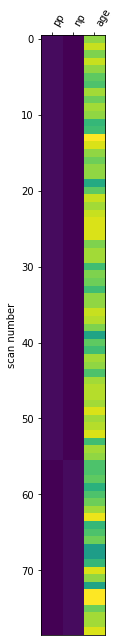

In [59]:
rerun_sec_lev_rtm = False

sec_lev_desi_rtm = pd.DataFrame({
    "pp": (data.loc[(subs_rtm,"T0",na()),:].group_str == "PP").astype(int),
    "np": (data.loc[(subs_rtm,"T0",na()),:].group_str == "NP").astype(int),
    "age": data.loc[(subs_rtm,"T0",na()),:].age
})

print(f"N = {data.loc[(subs_rtm,'T0',na()),:].shape[0]} subjects")
plot_design_matrix(sec_lev_desi_rtm, rescale=False)

#### Run only GCOR

In [60]:
# iterate voxe-wise measures
sec_level_res_rtm = {}
sec_level_res_rtm["gcor"] = {}

# RERUN
if rerun_sec_lev_rtm:
    
    # get data files
    vols = [load_img(d) for d in data.loc[(subs_rtm,"T0",na()), "gcor_path"].to_list()]
    
    # con1
    sec_level_res_rtm["gcor"]["con1"] = run_2nd_level(
        data=vols,
        design=sec_lev_desi_rtm,
        contrast_par=np.array([1, -1, 0]),
        contrast_nonpar=np.array([1, 0, 0]),
        save_dir=join(wd, "results"),
        save_prefix="RTM_gcor_con1_",
        cmap="cold_white_hot", 
        title=f"{measure}: PP > NP [-lg(p)]"
    )
    
    # con2
    sec_level_res_rtm["gcor"]["con2"] = run_2nd_level(
        data=vols,
        design=sec_lev_desi_rtm,
        contrast_par=np.array([-1, 1, 0]),
        contrast_nonpar=np.array([0, 1, 0]),
        save_dir=join(wd, "results"),
        save_prefix="RTM_gcor_con2_",
        cmap="cold_white_hot_r", 
        title=f"{measure}: PP < NP [-lg(p)]"
    )

else:
    # NOT RERUN, JUST LOAD SAVED FILES
    for con in ["con1", "con2"]:
        sec_level_res_rtm["gcor"][con] = {}
        for file in glob(join(wd, "results", f"RTM_gcor_{con}_*.nii.gz")):
            name = os.path.basename(file).replace(f"RTM_gcor_{con}_", "").replace(".nii.gz", "")
            sec_level_res_rtm["gcor"][con][name] = load_img(file)

# show results dict
sec_level_res_rtm

{'gcor': {'con1': {'map_par_logp': <nibabel.nifti1.Nifti1Image at 0x7f92f1c26a60>,
   'map_nonpar_logp': <nibabel.nifti1.Nifti1Image at 0x7f93008bc850>},
  'con2': {'map_par_logp': <nibabel.nifti1.Nifti1Image at 0x7f934522af10>,
   'map_nonpar_idx': <nibabel.nifti1.Nifti1Image at 0x7f9345fadd60>,
   'map_nonpar_logp': <nibabel.nifti1.Nifti1Image at 0x7f9345fadbe0>,
   'map_nonpar_bin': <nibabel.nifti1.Nifti1Image at 0x7f9345fad910>}}}

#### Extract cluster data

In [61]:
rerun_cl_extract_rtm = False

In [62]:
if rerun_cl_extract_rtm:

    # VOXEL-WISE
        
    # image data
    vols_func = [load_img(d) for d in data["gcor_path"].to_list()]
        
    for con in ["con1", "con2"]:
        
        # indexed thresholded image
        if "map_nonpar_idx" in sec_level_res_rtm["gcor"][con].keys():
            
            # masker
            masker = NiftiLabelsMasker(
                labels_img=sec_level_res["gcor"][con]["map_nonpar_idx"],
                standardize=False,
            )
            # extract functional and structural data
            temp_func = masker.fit_transform(vols_func)
            for cl in range(temp_func.shape[1]):
                data[f"rtm_gcor_{con}_cl{cl+1}"] = temp_func[:, cl]

    # SAVE    
    data.to_csv(join(wd, "pheno", "pprs_pheno_mri_proc_res_rtm.csv"))
    
else:
    data = pd.read_csv(join(wd, "pheno", "pprs_pheno_mri_proc_res_rtm.csv"))
    data = data.set_index(["idx_id", "idx_tp", "idx_group"])

### Spatial correlations

In [63]:
rerun_spc_rtm = False

In [64]:
if rerun_spc_rtm:
    
    # run
    res_jsp_rtm = dict()
    res_jsp_rtm["gcor"] = dict()
    res_jsp_rtm["gcor"]["T0"] = dict()

    jsp = JuSpyce(
        x=pd.concat([pred_aba, pred_pet], axis=1).T,
        y=data.loc[(subs_rtm, "T0", na()), "gcor_path"].to_list(),
        data_space="mni152",
        parcellation=parc,
        parcellation_space="mni152",
        parcellation_labels=parc_info.label.to_list(),
        y_labels=data.loc[(subs_rtm, "T0", na()),:].index,
        standardize="x",
        drop_nan=False,
        n_proc=8
    ).fit(verbose=False)
    
    groups = data.loc[(subs_rtm, "T0", na()), "group"].replace({0:2})
    
    jsp.compare(comparison="z(A,B)", groups=groups, verbose=False)
    jsp.predict(comparison="z(A,B)", method="spearman", r_to_z=True, verbose=False)
    jsp.predict(comparison="z(A,B)", method="mlr", adjust_r2=True, verbose=False)
    jsp.permute_groups(
        comparison="z(A,B)",
        groups=groups,
        method="spearman",
        p_from_average_y="mean",
        r_to_z=True,
        n_perm=10000,
        seed=42,
        verbose=True
    )

    res_jsp_rtm["gcor"]["T0"]["zr"] = jsp.predictions["z(A,B)-spearman"]
    res_jsp_rtm["gcor"]["T0"]["zrp"] = jsp.p_comparisons["z(A,B)-spearman-norm"]
    res_jsp_rtm["gcor"]["T0"]["r2"] = jsp.predictions["z(A,B)-mlr_full_r2"]    
        
    # collect results
    spc_zr_rtm = res_jsp_rtm["gcor"]["T0"]["zr"].assign(idx_metric="gcor").set_index("idx_metric", append=True)
    spc_sig_rtm = res_jsp_rtm["gcor"]["T0"]["zrp"].assign(idx_metric="gcor").set_index("idx_metric", append=True)
    spc_r2_rtm = res_jsp_rtm["gcor"]["T0"]["r2"].assign(idx_metric="gcor").set_index("idx_metric", append=True)
    #spc_sig.index = pd.MultiIndex.from_tuples([(m, tp) for m in metrics for tp in tps])
    
    # save
    spc_zr_rtm.to_csv(join(wd, "results", "rtm_spc_zr.csv"))
    spc_sig_rtm.to_csv(join(wd, "results", "rtm_spc_zr_sig.csv"))
    spc_r2_rtm.to_csv(join(wd, "results", "rtm_spc_r2.csv"))
    
else:
    
    # load
    spc_zr_rtm = pd.read_csv(join(wd, "results", "rtm_spc_zr.csv"), index_col=[0,1,2,3])
    spc_sig_rtm = pd.read_csv(join(wd, "results", "rtm_spc_zr_sig.csv"), index_col=[0,1])
    spc_r2_rtm = pd.read_csv(join(wd, "results", "rtm_spc_r2.csv"), index_col=[0,1,2,3])
    
    
# merge and print overview results
data_spc_rtm = data
data_spc_rtm = data_spc_rtm.merge(
    spc_zr_rtm.loc[na(),na(),na(), "gcor"].rename(columns=dict(zip(spc_zr_rtm.columns, ["rtm_gcor_"+c for c in spc_zr_rtm.columns]))), 
    left_index=True, 
    right_index=True
)

print("Average Spearman colocalization")
display(spc_zr_rtm.groupby(["idx_metric", "idx_tp"], sort=False).mean().loc[(na(), "T0"),:].round(2))
print("Associated group-permutation p-values")
display(spc_sig_rtm)
print("Average R2")
display(spc_r2_rtm.groupby(["idx_metric", "idx_tp"], sort=False).mean().loc[(na(), "T0"),:].round(2))

Average Spearman colocalization


PGR  ESR1  ESR2  NR3C1  NR3C2  OXTR  GABAa  mGluR5
idx_metric idx_tp                                                     
gcor       T0     -0.09 -0.05  0.02   0.18   0.19 -0.21   0.09    0.04

Associated group-permutation p-values


PGR      ESR1      ESR2     NR3C1     NR3C2  \
            idx_metric                                                     
mean-z(A,B) gcor        0.008897  0.061446  0.348938  0.002056  0.002224   

                            OXTR     GABAa    mGluR5  
            idx_metric                                
mean-z(A,B) gcor        0.000667  0.041195  0.372395

Average R2


mlr_full_r2
idx_metric idx_tp             
gcor       T0              0.2

### Repeat longitudinal analyses

In [65]:
cl_iter_rtm = [
    ('rtm_gcor_con2_cl1', 'GCOR', 'PP < NP', 'leftPut'),
    ('rtm_gcor_con2_cl2', 'GCOR', 'PP < NP', 'rightPut')
]

mri_long_lmm_rtm = list()

for lab, measure, contrast, name in cl_iter_rtm:
    print(lab)
    
    # longitudinal data, only PP, doesnt matter if all timepoints
    temp_mri_long = data.loc[(subs_PP_long, na(), "PP"), :]
    
    # calculate LMM and pairwise paired t tests
    lmm = smf.mixedlm(f"{lab} ~ weeks_postpartal", data=temp_mri_long, groups="ID").fit()
    lmm2 = smf.mixedlm(f"{lab} ~ weeks_postpartal + np.square(weeks_postpartal)", data=temp_mri_long, groups="ID").fit()

    temp_df = pd.DataFrame({
        "Measure": measure,
        "Contrast": contrast,
        "Cluster name": name,
        ("", "df"): f"({lmm.df_modelwc}, {lmm.df_resid})",
        ("Weeks PP", "converged"): lmm.converged,
        ("Weeks PP", "coef"): lmm.params["weeks_postpartal"].round(4),
        ("Weeks PP", "-lg(p)"): -np.log10(lmm.pvalues["weeks_postpartal"]).round(3),
        ("Weeks PP^2", "converged"): lmm2.converged,
        ("Weeks PP^2", "coef"): lmm2.params["np.square(weeks_postpartal)"].round(4),
        ("Weeks PP^2", "-lg(p)"): -np.log10(lmm2.pvalues["np.square(weeks_postpartal)"]).round(3),
    }, index=range(1))
    
    # save
    temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
    mri_long_lmm_rtm.append(temp_df)
        
mri_long_lmm_rtm = pd.concat(mri_long_lmm_rtm)
mri_long_lmm_rtm.columns = pd.MultiIndex.from_tuples(mri_long_lmm_rtm.columns)

mri_long_lmm_rtm.to_csv(join(wd, "tables", "rtm_mri_longitudinal_lmm_stat.csv"))
mri_long_lmm_rtm.to_html(join(wd, "tables", "rtm_mri_longitudinal_lmm_stat.html"))
mri_long_lmm_rtm

rtm_gcor_con2_cl1
rtm_gcor_con2_cl2


Weeks PP                Weeks PP^2  \
                                     df converged    coef -lg(p)  converged   
Measure Contrast Cluster name                                                 
GCOR    PP < NP  leftPut       (3, 108)      True  0.0215  3.167       True   
                 rightPut      (3, 108)      True  0.0199  3.367       True   

                                              
                                 coef -lg(p)  
Measure Contrast Cluster name                 
GCOR    PP < NP  leftPut      -0.0015  1.251  
                 rightPut     -0.0017  1.837

## Plots

### MRI brains

/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = getattr(ax, type)(data_2d.copy(),
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


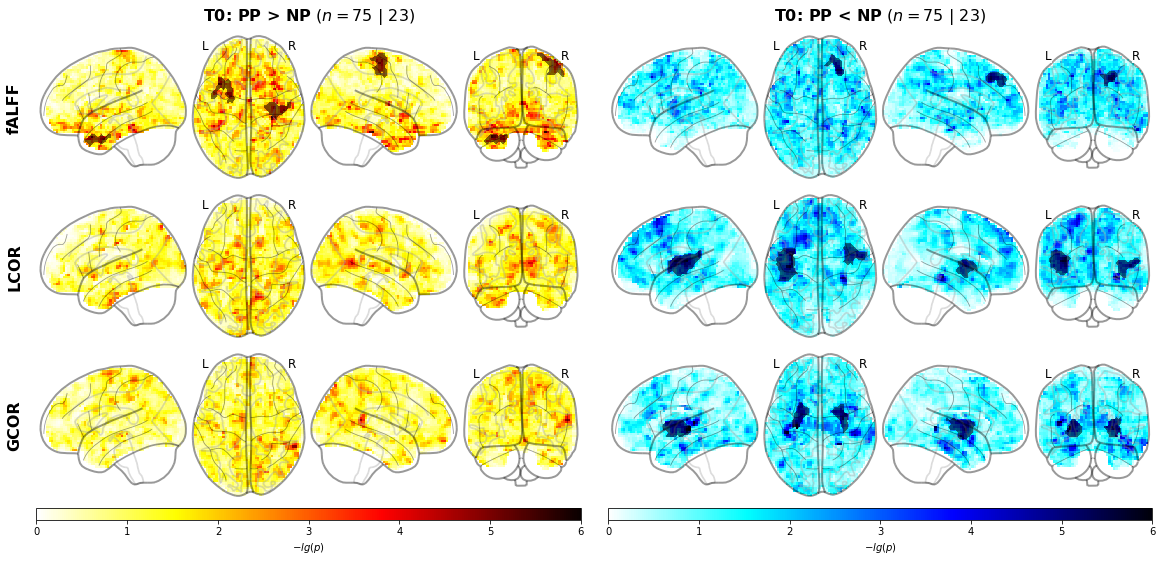

In [44]:
vmin = 0
vmax = 6

fig, axes = plt.subplots(4,2, figsize=(20,9),
                         gridspec_kw=dict(
                             hspace=0.05, 
                             wspace=0.05, 
                             height_ratios=(1,1,1, 0.08)))

# iterate contrasts
for c, con, con_name in zip(
    range(2), 
    ["con1", "con2"],
    ["PP > NP", "PP < NP"]):
    
    # VOXELWISE BRAINS
    for r, measure, measure_name in zip(
        range(3), 
        ["falff", "lcor", "gcor"], 
        ["fALFF", "LCOR", "GCOR"]):
        
        # get maps
        map_unthresh = sec_level_res[measure][con]["map_par_logp"]
        map_thresh = sec_level_res[measure][con]["map_nonpar_logp"]
        
        # plot main glass brain
        gb = plot_glass_brain(
            map_unthresh, 
            display_mode="lzry",
            alpha=0.4,
            colorbar=False, 
            cmap="cold_white_hot" if con=="con1" else "cold_white_hot_r",
            figure=fig,
            axes=axes[r,c],
            vmin=vmin,
            vmax=vmax
        )
        
        # significant cluster
        if (map_thresh.get_fdata() > cl_thresh).any():
            
            # plot overlays
            gb.add_contours(
                img=threshold_img(map_thresh, cl_thresh), 
                levels=[1], 
                colors="k", 
                linewidth=5,
                filled=True,
                alpha=0.5
            )
        
        # titles
        if r==0:
            axes[r,c].set_title(f"T0: {con_name} $(n = {data.loc[(na(),'T0','PP'),:].shape[0]}\ |\ "
                                f"{data.loc[(na(),'T0','NP'),:].shape[0]})$", 
                                size=16, weight="semibold", pad=10)
        if c==0: 
            axes[r,c].annotate(
                measure_name, 
                xy=(-0.04,0.5), 
                xycoords="axes fraction", 
                rotation=90,
                size=16, weight="semibold", ha="center", va="center"
            )
    
    # COLORBAR
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(
        cmap="black_red_r" if con=="con1" else "black_blue_r", 
        norm=norm)
    sm.set_array([])
    plt.colorbar(
        sm,
        label=r"$-lg(p)$",
        orientation="horizontal",
        cax=axes[3,c],
    )
    
# save
fig.savefig(join(wd, "plots", "fig1_brains.pdf"), bbox_inches="tight")

### MRI group comparisons & development

In [45]:
def where(condition, x, y):
    out = np.where(condition, x, y)
    if isinstance(condition, pd.DataFrame):
        out = pd.DataFrame(out, columns=condition.columns, index=condition.index)
    return out

def lgp_to_star(lgp_array, lgq_array, empty=""):
    lgp_array_flat = np.array(lgp_array).flatten()
    lgq_array_flat = np.array(lgq_array).flatten()
    a = list()
    for lgp, lgq in zip(lgp_array_flat, lgq_array_flat):
        if lgq > -np.log10(0.05): a.append("★")
        elif lgp > -np.log10(0.05): a.append("☆")
        else: a.append(empty)
    
    return np.array(a).reshape(lgp_array.shape, order="C")

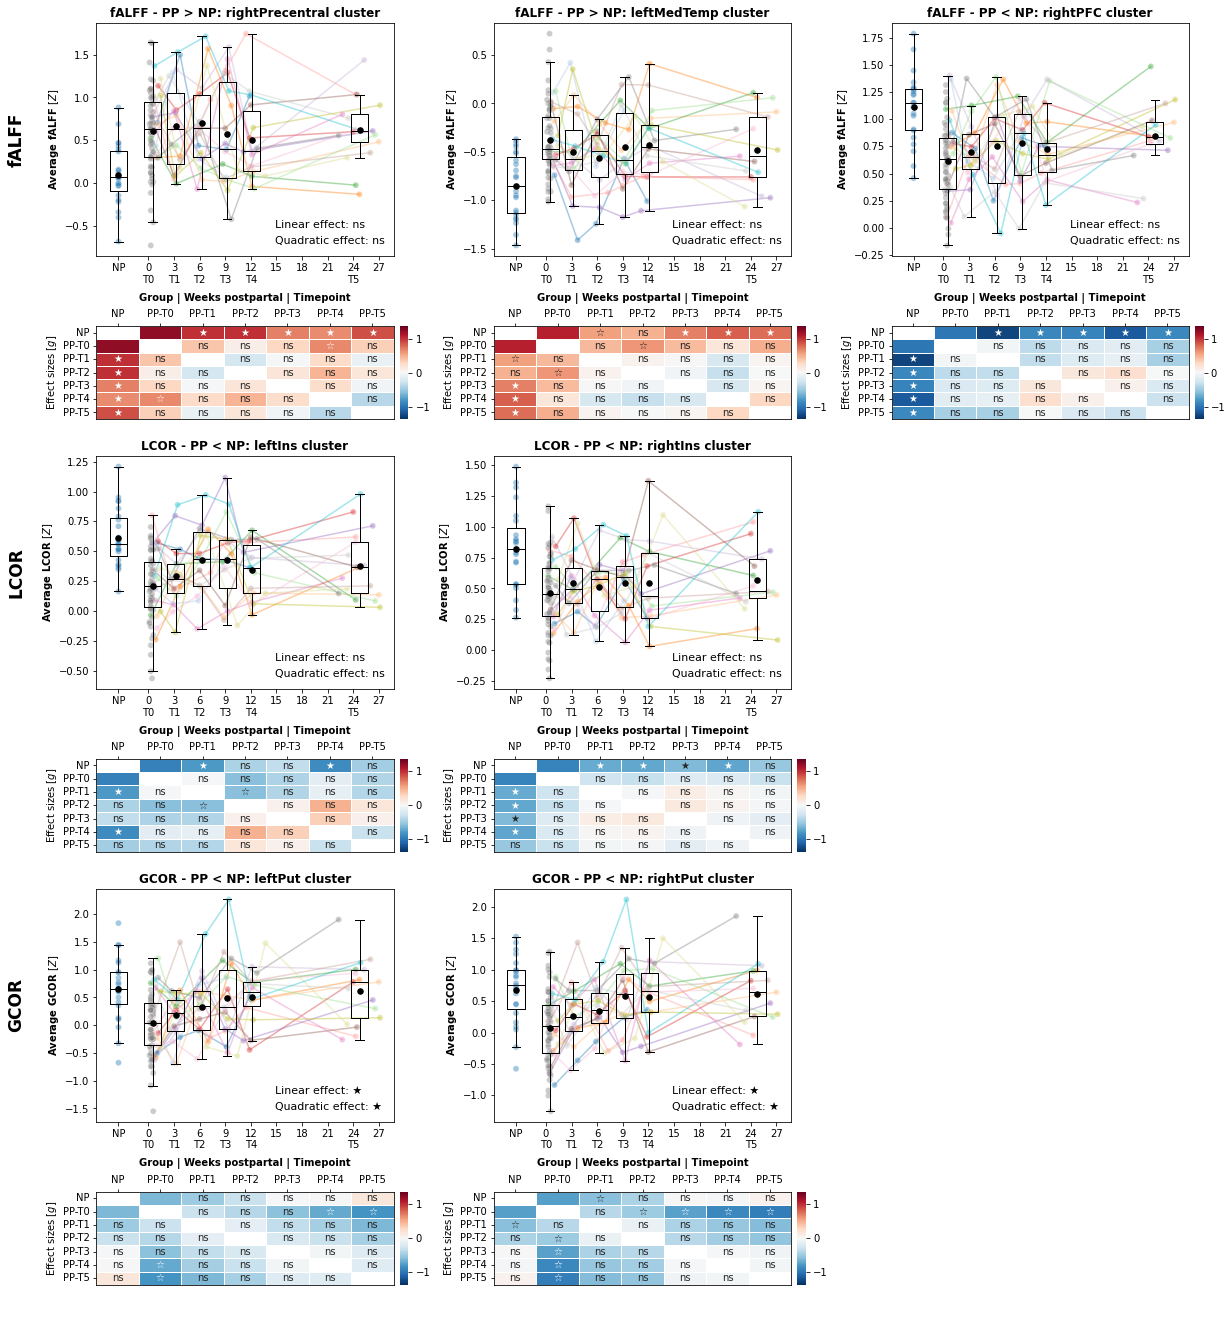

In [46]:
# colors
colors = dict()
for sub in subs_NP: colors[sub] = "tab:blue"
for sub in [s for s in subs_PP if s not in subs_PP_long]: colors[sub] = "0.5"
for i, sub in enumerate(subs_PP_long): colors[sub] = get_cmap("tab20")(i)

# maximum effect size
es_lim = np.nanmax(np.abs(np.r_[
    mri_bl_confounds[("ANCOVA: PP vs. NP: Age", "g")].values,
    mri_long_unpaired[(f"ANCOVA: PP-{tp} vs. NP: Age", "g")].values,
    mri_long_paired.loc[:, (na(), "g")].values.flatten()
]))

fig, axes = plt.subplots(3,3, figsize=(17,18), sharex=False, constrained_layout=True)
axes = axes.ravel()

for (lab, measure, contrast, name), i in zip(cl_iter, [0,1,2, 3,4, 6,7]):
    
    temp_mri = pd.concat(
        [data.loc[(subs_NP, ), :].melt(["ID", "group_str", "weeks_postpartal"], lab), # all NP
         data.loc[(subs_PP, "T0", ), :].melt(["ID", "group_str", "weeks_postpartal"], lab).replace({"PP": "PP-T0"})] + \
        [data.loc[(subs_PP_long, tp), :].melt(["ID", "group_str", "weeks_postpartal"], lab).replace({"PP": f"PP-{tp}"}) for tp in ["T1", "T2", "T3", "T4", "T5"]]
    )
    temp_mri.loc[temp_mri.group_str=="NP", "weeks_postpartal"] = -3.5

    sns.scatterplot(
        temp_mri,
        x="weeks_postpartal",
        hue="ID",
        y="value",
        ax=axes[i],
        legend=None,
        alpha=0.4,
        zorder=3,
        palette=colors
    )
    sns.lineplot(
        temp_mri,
        x="weeks_postpartal",
        y="value",
        hue="ID",
        ax=axes[i],
        legend=None,
        alpha=0.4,
        zorder=2,
        palette=colors
    )
    
    for group in temp_mri.group_str.unique():   

        axes[i].boxplot(
            x=temp_mri.loc[temp_mri.group_str==group, "value"],
            positions=[temp_mri.loc[temp_mri.group_str==group, "weeks_postpartal"].mean()],
            widths=2,
            zorder=10,
            showfliers=False,
            medianprops=dict(c="k")       
        )
        axes[i].scatter(
            y=[temp_mri.loc[temp_mri.group_str==group, "value"].mean()],
            x=[temp_mri.loc[temp_mri.group_str==group, "weeks_postpartal"].mean()],
            zorder=11,
            c="k",
            s=30
        )
    
    # LMM
    for var in ["Weeks PP", "Weeks PP^2"]:
        p = mri_long_lmm.loc[(measure, contrast, name), (var, "-lg(p)")]
        q =  mri_long_lmm.loc[(measure, contrast, name), (var, "-lg(q)")]
        if q > -np.log10(0.05): s = "★"
        elif p > -np.log10(0.05): s = "☆"
        else: s = "ns"
        axes[i].annotate(
            f"{'Linear' if var=='Weeks PP' else 'Quadratic'} effect: {s}",
            xy=(0.6, 0.05 + (0.07 if var=='Weeks PP' else 0)),
            xycoords="axes fraction",
            size=11
        )
    
    # Labels
    axes[i].set_title(f"{measure} - {contrast}: {name} {'cluster' if measure!='NBS' else 'average connectivity'}", weight="semibold")
    axes[i].set_ylabel(f"Average {measure if measure!='NBS' else 'network connectivity'} $[Z]$", weight="semibold")
    axes[i].set_xticks([-3.5] + list(range(0,28,3)))
    axes[i].set_xticklabels(["NP", "0\nT0", "3\nT1", "6\nT2", "9\nT3", "12\nT4", "15", "18", "21", "24\nT5", "27"])
    axes[i].set_xlabel("Group | Weeks postpartal | Timepoint", weight="semibold", labelpad=8)
    
    
    # significance
    comp_p = pd.DataFrame(
        np.zeros((7,7)),
        columns=["NP"]+[f"PP-{tp}" for tp in tps],
        index=["NP"]+[f"PP-{tp}" for tp in tps]
    )
    comp_q, comp_es = comp_p.copy(), comp_p.copy()

    # NP vs PP T0
    comp_p.loc["NP", "PP-T0"] = mri_bl_confounds.loc[(measure, contrast, name), ("ANCOVA: PP vs. NP: Age", "-lg(p)")]
    comp_q.loc["NP", "PP-T0"] = mri_bl_confounds.loc[(measure, contrast, name), ("ANCOVA: PP vs. NP: Age", "-lg(p)")]
    comp_es.loc["NP", "PP-T0"] = mri_bl_confounds.loc[(measure, contrast, name), ("ANCOVA: PP vs. NP: Age", "g")]

    # NP vs PP each timepoint
    for tp in tps:
        comp_p.loc["NP", f"PP-{tp}"] = mri_long_unpaired.loc[(measure, contrast, name), (f"ANCOVA: PP-{tp} vs. NP: Age", "-lg(p)")]
        comp_q.loc["NP", f"PP-{tp}"] = mri_long_unpaired.loc[(measure, contrast, name), (f"ANCOVA: PP-{tp} vs. NP: Age", "-lg(q)")]
        comp_es.loc["NP", f"PP-{tp}"] = mri_long_unpaired.loc[(measure, contrast, name), (f"ANCOVA: PP-{tp} vs. NP: Age", "g")]
        
    # PP vs PP each combi
    for k in [c for c in mri_long_paired.columns if ("T-test" in c[0]) & (c[1]=="-lg(p)")]:
        comp_p.loc["PP-"+k[0].split(" ")[1], "PP-"+k[0].split(" ")[3]] = mri_long_paired.loc[(measure, contrast, name), k]
        comp_es.loc["PP-"+k[0].split(" ")[1], "PP-"+k[0].split(" ")[3]] = mri_long_paired.loc[(measure, contrast, name), (k[0], "g")]
        
    for k in [c for c in mri_long_paired.columns if ("T-test" in c[0]) & (c[1]=="-lg(q)")]:
        comp_q.loc["PP-"+k[0].split(" ")[1], "PP-"+k[0].split(" ")[3]] = mri_long_paired.loc[(measure, contrast, name), k]

    comp_es = comp_es + comp_es.T
    comp_es = comp_es.replace({np.nan:0})
    comp_p = comp_p + comp_p.T
    comp_q = comp_q + comp_q.T
    comp_sig = lgp_to_star(comp_p, comp_q, "ns")
    comp_sig[0,1] = ""
    comp_sig[1,0] = ""
    mask = np.zeros((7,7))
    np.fill_diagonal(mask, 1)
    
    # plot heatmap
    #lim = comp_es.abs().max().max()
    sig_ax = axes[i].inset_axes((0,-0.7,1,0.4))
    cbar_ax = axes[i].inset_axes((1.02,-0.7,0.03,0.4)) # (0.3,-0.55,0.4,0.04)
    dist_ax = axes[i].inset_axes((0,-0.85,1,0.1))
    dist_ax.axis("off")
    ax = sns.heatmap(
        comp_es,
        vmin=-es_lim,
        vmax=es_lim,
        cmap="RdBu_r",
        cbar=True,
        cbar_ax=cbar_ax,
        cbar_kws=dict(orientation="vertical"),
        annot=comp_sig,
        linewidths=1,
        linecolor="w",
        fmt="s",
        mask=mask,
        ax=sig_ax
    )
    ax.xaxis.tick_top()
    ax.set_yticks(np.arange(0.5,6.6))
    ax.set_yticklabels(["NP"]+[f"PP-{tp}" for tp in tps], rotation=0)
    ax.set_ylabel("Effect sizes $[g]$")
    [spine.set_visible(True) for _, spine in ax.spines.items()]
    
    if i in [0,3,6]:
        axes[i].annotate(
            measure, 
            xy=(-0.27,0.5), 
            xycoords="axes fraction", 
            rotation=90,
            size=17, weight="semibold", ha="center", va="center"
        )
    
[ax.axis("off") for ax in axes if ax.axis() == (0.0, 1.0, 0.0, 1.0)]

# save
fig.savefig(join(wd, "plots", "fig2_boxes.pdf"), bbox_inches="tight")

### Spatial associations

fALFF PGR
fALFF mGluR5
GCOR PGR
GCOR NR3C2
GCOR OXTR


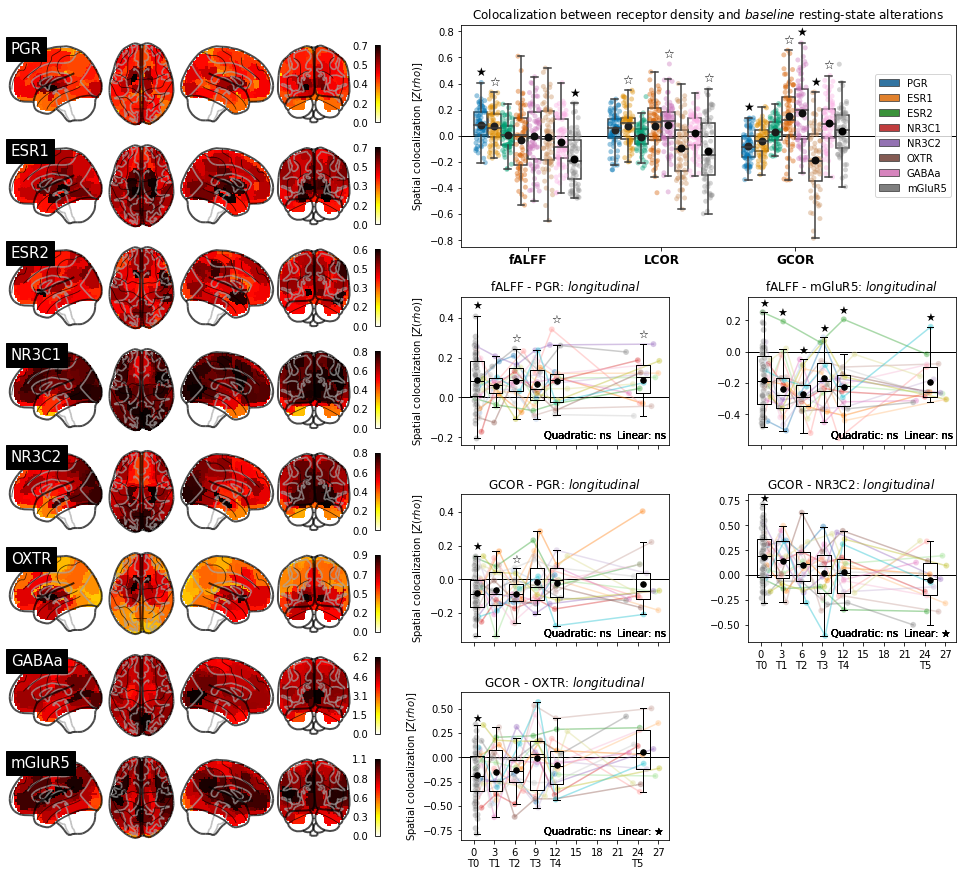

In [47]:
fig = plt.figure(figsize=(17,15))
gs = GridSpec(4, 3, figure=fig, 
              width_ratios=(1.8,1,1), height_ratios=(1.5,1,1,1),
              hspace=0.3, wspace=0.3)

# brains

temp = pd.concat([pred_aba, pred_pet], axis=1)
ax_brain = fig.add_subplot(gs[:,0])
ax_brain.set_axis_off()
for i, atlas in enumerate(temp.columns):
    ax = ax_brain.inset_axes((0, (8-1-i)*(1/8), 1, 1/8 - 0.02))
    if i < 12:
        plot_glass_brain(
            parcel_data_to_volume(temp[atlas].values, parc)[0], 
            colorbar=True, 
            title=atlas, 
            plot_abs=False,
            display_mode="lzry",
            annotate=False,
            axes=ax,
            cbar_tick_format="%.1f",
            #cmap="cold_hot"
        )

# baseline plot

ax_base = fig.add_subplot(gs[0,1:])
temp = spc_zr.loc[(na(), "T0", "PP"),:].reset_index().melt(id_vars="idx_metric", value_vars=spc_zr.columns)
sns.stripplot(
    temp,
    x="idx_metric",
    hue="variable",
    y="value",
    dodge=True,
    ax=ax_base,
    palette="colorblind",
    jitter=0.3,
    legend=None,
    alpha=0.4,
    zorder=1
)
sns.boxplot(
    temp,
    x="idx_metric",
    hue="variable",
    y="value",
    ax=ax_base,
    fliersize=0,
    boxprops=dict(facecolor="none"),
    zorder=2,
    linewidth=1.5,
)
sns.pointplot(
    temp,
    x="idx_metric",
    hue="variable",
    y="value",
    ax=ax_base,
    dodge=0.7,
    scale=0.9,
    join=False,
    label="",
    color="k",
    errorbar=None
)
for x, m in enumerate(metrics):
    for x_adj, r in zip(np.linspace(-0.35,0.35,8), spc_zr.columns):
        
        if spc_cross.loc[(m,r), ("T0", "q")] < 0.05: s = "★"
        elif spc_cross.loc[(m,r), ("T0", "p")] < 0.05: s = "☆"
        else: s = ""
        ax_base.text(
            s=s, 
            x=x+x_adj, 
            y=spc_zr.loc[(na(), "T0", "PP", m), r].max() + 0.08, 
            ha="center", va="center", size=12
        )  
ax_base.axhline(c="k", zorder=0, lw=1)
ax_base.set_xlabel("")
ax_base.set_ylim(-0.85,0.85)
ax_base.set_xlim(None, 3.2)
ax_base.set_xticklabels(metrics, weight="semibold", size=12)
ax_base.set_ylabel("Spatial colocalization $[Z(rho)]$")
ax_base.set_title("Colocalization between receptor density and $baseline$ resting-state alterations")
handles, labels = ax_base.get_legend_handles_labels()
ax_base.legend(handles=handles[:8], labels=labels[:8], loc="center right") # bbox_to_anchor=(1.1,0.5)

# longitudinal plots

# colors
colors = dict()
for sub in subs_NP: colors[sub] = "tab:blue"
for sub in [s for s in subs_PP if s not in subs_PP_long]: colors[sub] = "0.5"
for i, sub in enumerate(subs_PP_long): colors[sub] = get_cmap("tab20")(i)

temp = spc_cross[spc_cross.loc[:, ("T0", "q")] < 0.05]
axes = [fig.add_subplot(gs[1,1]), fig.add_subplot(gs[1,2]),
        fig.add_subplot(gs[2,1]), fig.add_subplot(gs[2,2]),
        fig.add_subplot(gs[3,1])]#, fig.add_subplot(gs[6:8,2]), fig.add_subplot(gs[6:8,3])]

for i, (idx, ax) in enumerate(zip(temp.index, axes)):
    m, r = idx
    print(m, r)
    
    temp = data_spc.loc[(na(), na(), "PP"), [f"{m}_{r}", "weeks_postpartal", "ID"]]
    sns.scatterplot(
        temp,
        x="weeks_postpartal",
        hue="ID",
        y=f"{m}_{r}",
        ax=ax,
        legend=None,
        alpha=0.4,
        zorder=3,
        palette=colors
    )
    sns.lineplot(
        temp,
        x="weeks_postpartal",
        y=f"{m}_{r}",
        hue="ID",
        ax=ax,
        legend=None,
        alpha=0.4,
        zorder=2,
        palette=colors
    )
    temp_mean = temp.groupby("idx_tp").mean()
    temp_max = temp.groupby("idx_tp").max()
    for tp in tps:   
        ax.boxplot(
            x=temp.loc[(na(), tp, "PP"), f"{m}_{r}"],
            positions=[temp_mean.loc[tp, "weeks_postpartal"]],
            widths=2,
            zorder=10,
            showfliers=False,
            medianprops=dict(c="k")       
        )
        ax.scatter(
            y=temp_mean.loc[tp, f"{m}_{r}"],
            x=temp_mean.loc[tp, "weeks_postpartal"],
            zorder=11,
            c="k",
            s=30
        )        
        if spc_cross.loc[(m,r), (tp, "q")] < 0.05: s = "★"
        elif spc_cross.loc[(m,r), (tp, "p")] < 0.05: s = "☆"
        else: s = ""
        ax.text(
            s=s, 
            x=temp_mean.loc[tp, "weeks_postpartal"], 
            y=temp_max.loc[tp, f"{m}_{r}"] + 0.05,
            ha="center", va="center", size=11
        )  
        # LMM
        for var in ["Weeks PP", "Weeks PP^2"]:
            if spc_long.loc[(m,r), (var, "q")] < 0.05: s = "★"
            elif spc_long.loc[(m,r), (var, "p")] < 0.05: s = "☆"
            else: s = "ns"
            ax.annotate(
                f"{'Linear' if var=='Weeks PP' else 'Quadratic'}: {s}",
                xy=(0.4 + (0.35 if var=='Weeks PP' else 0), 0.04),
                xycoords="axes fraction",
                ha="left",
                size=10
            )
    ax.set_ylim(None, temp_max[f"{m}_{r}"].max() + 0.1)
    ax.axhline(c="k", zorder=0, lw=1)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks(list(range(0,28,3)))
    ax.set_xticklabels([])
    ax.set_title(f"{m} - {r}: $longitudinal$")
    
for i in [0,2,4]:
    axes[i].set_ylabel("Spatial colocalization $[Z(rho)]$")
for i in [3,4]:
    axes[i].set_xticklabels(["0\nT0", "3\nT1", "6\nT2", "9\nT3", "12\nT4", "15", "18", "21", "24\nT5", "27"])

fig.savefig(join(wd, "plots", "fig3_spatial_correlations.pdf"), bbox_inches="tight")

### Behavioral and hormonal associations

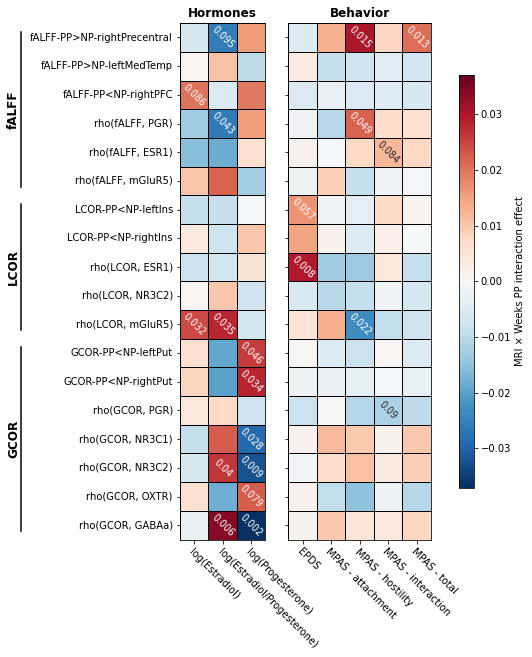

In [75]:
fig, axes = plt.subplots(1,2, figsize=(4.5,9.5), sharey=True, gridspec_kw=dict(width_ratios=(0.6,1)))

y_labs = assoc_behav[("Interaction", "coef")].index.get_level_values("X").unique()
y_labs = [c for c in y_labs if "fALFF" in c] + [c for c in y_labs if "LCOR" in c] + [c for c in y_labs if "GCOR" in c]
 
lim = np.max(np.abs(assoc_behav[("Interaction", "coef")].to_list() + assoc_horm[("Interaction", "coef")].to_list()))

for i, (title, coef, p) in enumerate(zip(
    ["Hormones", "Behavior"],
    [assoc_horm[("Interaction", "coef")].reset_index().pivot(columns="Y", index="X"),
     assoc_behav[("Interaction", "coef")].reset_index().pivot(columns="Y", index="X")],
    [assoc_horm[("Interaction", "p")].reset_index().pivot(columns="Y", index="X"),
     assoc_behav[("Interaction", "p")].reset_index().pivot(columns="Y", index="X")]
)):
    
    annot = p.round(3).astype(str)
    annot[p > 0.1] = ""

    if i==1:
        ax_cbar = axes[i].inset_axes((1.2,0.1,0.1,0.8))
    sns.heatmap(
        data=coef.loc[y_labs],
        cmap="RdBu_r",
        vmin=-lim,
        vmax=lim,
        center=0,
        ax=axes[i],
        cbar=True if i==1 else False,
        cbar_ax=ax_cbar if i==1 else None,
        cbar_kws=dict(label="MRI × Weeks PP interaction effect"),
        square=False,
        linewidths=1,
        linecolor="k",
        annot=annot.loc[y_labs],
        fmt="s",
        annot_kws=dict(size=9.5, rotation=-45, ha="center", va="center")
    )
    if i==1:
        ax_cbar.spines["outline"].set(visible=True, lw=.8, edgecolor="black")
    sns.despine(top=False, right=False, bottom=False, left=False)
    axes[i].set_title(title, weight="semibold")
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")
    axes[i].set_xticklabels([l.replace("Interaction-","") for l in coef.columns.get_level_values(2)],
                            rotation=-45, ha="left", rotation_mode="anchor")

ax = axes[0].inset_axes((-1.9,0,0.1,1))
ax.set_ylim(axes[0].get_ylim())
ax.set_axis_off()
n_falff = len([c for c in y_labs if "fALFF" in c])
n_lcor = len([c for c in y_labs if "LCOR" in c])
n_gcor = len([c for c in y_labs if "GCOR" in c])
for r, m in zip([(0.5, n_falff-0.5), 
                 (n_falff+0.5, n_falff+n_lcor-0.5), 
                 (n_falff+n_lcor+0.5, n_falff+n_lcor+n_gcor+-0.5)], 
                metrics):
    ax.plot([0,0], [r[0]-0.2, r[1]+0.2], c="k")
    ax.text(s=m, x=-0.1, y=np.mean(r), rotation=90, va="center", ha="center", size=12, weight="semibold")
    
fig.savefig(join(wd, "plots", "fig4_associations.pdf"), bbox_inches="tight")

### RTM sensitivity

/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = getattr(ax, type)(data_2d.copy(),


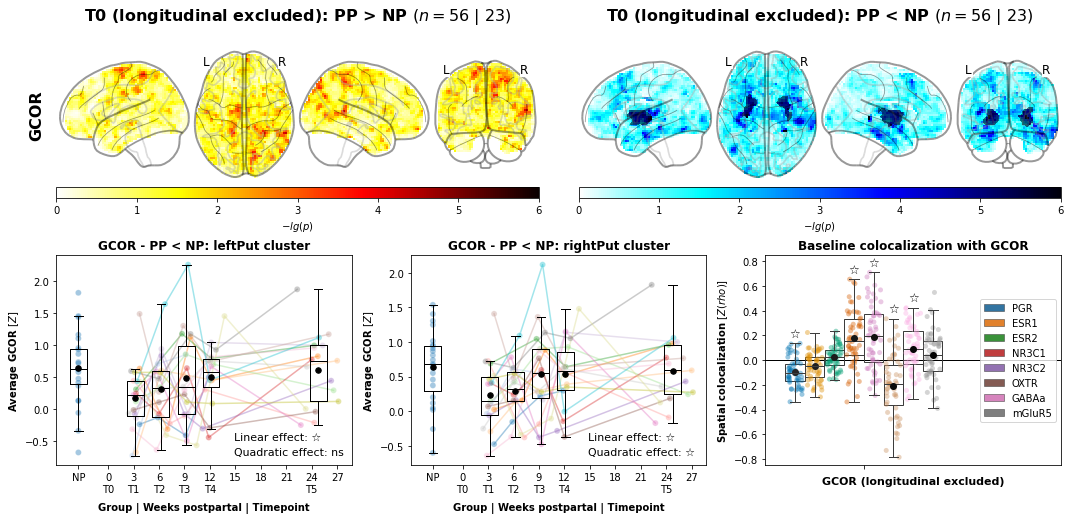

In [49]:
fig = plt.figure(figsize=(18,8))
gs = GridSpec(2, 3, figure=fig, 
              width_ratios=(1,1,1), height_ratios=(0.8,1),
              hspace=0.3, wspace=0.2)

# GLM brains
ax_brain = fig.add_subplot(gs[0,:])
ax_brain.set_axis_off()
ax_brain_con1 = ax_brain.inset_axes((0,0,0.48,1))
ax_brain_con2 = ax_brain.inset_axes((0.52,0,0.48,1))

vmin = 0
vmax = 6

for con, ax in zip(["con1", "con2"], [ax_brain_con1, ax_brain_con2]):
    
    map_unthresh = sec_level_res_rtm["gcor"][con]["map_par_logp"]
    map_thresh = sec_level_res_rtm["gcor"][con]["map_nonpar_logp"]
        
    # plot main glass brain
    gb = plot_glass_brain(
        map_unthresh, 
        display_mode="lzry",
        alpha=0.4,
        colorbar=False, 
        cmap="cold_white_hot" if con=="con1" else "cold_white_hot_r",
        figure=fig,
        axes=ax,
        vmin=vmin,
        vmax=vmax
    )
        
    # significant cluster
    if (map_thresh.get_fdata() > cl_thresh).any():
        
        # plot overlays
        gb.add_contours(
            img=threshold_img(map_thresh, cl_thresh), 
            levels=[1], 
            colors="k", 
            linewidth=5,
            filled=True,
            alpha=0.5
        )
    
    # titles
    ax.set_title(f"T0 (longitudinal excluded): PP {'>' if con=='con1' else '<'} NP $(n = {data.loc[(subs_rtm,'T0','PP'),:].shape[0]}\ |\ "
                    f"{data.loc[(subs_rtm,'T0','NP'),:].shape[0]})$", 
                    size=16, weight="semibold", pad=10)
    if con=="con1": 
        ax.annotate(
            "GCOR", 
            xy=(-0.04,0.5), 
            xycoords="axes fraction", 
            rotation=90,
            size=16, weight="semibold", ha="center", va="center"
        )
    
    # colorbar
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(
        cmap="black_red_r" if con=="con1" else "black_blue_r", 
        norm=norm)
    sm.set_array([])
    plt.colorbar(
        sm,
        label=r"$-lg(p)$",
        orientation="horizontal",
        cax=ax.inset_axes((0,0,1,0.07)),
    )
    

# Cluster development

ax_clust1 = fig.add_subplot(gs[1,0])
ax_clust2 = fig.add_subplot(gs[1,1])

for (lab, measure, contrast, name), ax in zip(cl_iter_rtm, [ax_clust1, ax_clust2]):
    
    temp_mri = pd.concat(
        [data.loc[(subs_NP, ), :].melt(["ID", "group_str", "weeks_postpartal"], lab)] + \
        [data.loc[(subs_PP_long, tp), :].melt(["ID", "group_str", "weeks_postpartal"], lab).replace({"PP": f"PP-{tp}"}) for tp in ["T1", "T2", "T3", "T4", "T5"]]
    )
    temp_mri.loc[temp_mri.group_str=="NP", "weeks_postpartal"] = -3.5

    sns.scatterplot(
        temp_mri,
        x="weeks_postpartal",
        hue="ID",
        y="value",
        ax=ax,
        legend=None,
        alpha=0.4,
        zorder=3,
        palette=colors
    )
    sns.lineplot(
        temp_mri,
        x="weeks_postpartal",
        y="value",
        hue="ID",
        ax=ax,
        legend=None,
        alpha=0.4,
        zorder=2,
        palette=colors
    )
    
    for group in temp_mri.group_str.unique():   

        ax.boxplot(
            x=temp_mri.loc[temp_mri.group_str==group, "value"],
            positions=[temp_mri.loc[temp_mri.group_str==group, "weeks_postpartal"].mean()],
            widths=2,
            zorder=10,
            showfliers=False,
            medianprops=dict(c="k")       
        )
        ax.scatter(
            y=[temp_mri.loc[temp_mri.group_str==group, "value"].mean()],
            x=[temp_mri.loc[temp_mri.group_str==group, "weeks_postpartal"].mean()],
            zorder=11,
            c="k",
            s=30
        )
    
    # LMM
    for var in ["Weeks PP", "Weeks PP^2"]:
        p = mri_long_lmm_rtm.loc[(measure, contrast, name), (var, "-lg(p)")]
        if p > -np.log10(0.05): s = "☆"
        else: s = "ns"
        ax.annotate(
            f"{'Linear' if var=='Weeks PP' else 'Quadratic'} effect: {s}",
            xy=(0.6, 0.05 + (0.07 if var=='Weeks PP' else 0)),
            xycoords="axes fraction",
            size=11
        )
    
    # Labels
    ax.set_title(f"{measure} - {contrast}: {name} {'cluster' if measure!='NBS' else 'average connectivity'}", weight="semibold")
    ax.set_ylabel(f"Average {measure if measure!='NBS' else 'network connectivity'} $[Z]$", weight="semibold")
    ax.set_xticks([-3.5] + list(range(0,28,3)))
    ax.set_xticklabels(["NP", "0\nT0", "3\nT1", "6\nT2", "9\nT3", "12\nT4", "15", "18", "21", "24\nT5", "27"])
    ax.set_xlabel("Group | Weeks postpartal | Timepoint", weight="semibold", labelpad=8)
    

# SPC at baseline

ax_spc = fig.add_subplot(gs[1,2])
temp = spc_zr_rtm.loc[(na(), "T0", "PP"),:].reset_index().melt(id_vars="idx_metric", value_vars=spc_zr_rtm.columns)

sns.stripplot(
    temp,
    x="idx_metric",
    hue="variable",
    y="value",
    dodge=True,
    ax=ax_spc,
    palette="colorblind",
    jitter=0.3,
    legend=None,
    alpha=0.4,
    zorder=1
)
sns.boxplot(
    temp,
    x="idx_metric",
    hue="variable",
    y="value",
    ax=ax_spc,
    fliersize=0,
    boxprops=dict(facecolor="none"),
    zorder=2,
    linewidth=1,
)
sns.pointplot(
    temp,
    x="idx_metric",
    hue="variable",
    y="value",
    ax=ax_spc,
    dodge=0.7,
    scale=0.8,
    join=False,
    label="",
    color="k",
    errorbar=None
)

for x_adj, r in zip(np.linspace(-0.35,0.35,8), spc_zr_rtm.columns):
    
    if spc_sig_rtm[r].values[0] < 0.05: s = "☆"
    else: s = ""
    ax_spc.text(
        s=s, 
        x=x_adj, 
        y=spc_zr_rtm.loc[(na(), "T0", "PP", "gcor"), r].max() + 0.08, 
        ha="center", va="center", size=12
    )  
        
ax_spc.axhline(c="k", zorder=0, lw=1)
ax_spc.set_xticklabels([])
ax_spc.set_ylim(-0.85,0.85)
ax_spc.set_xlim(None, 1)
ax_spc.set_xlabel("GCOR (longitudinal excluded)", weight="semibold", size=11)
ax_spc.set_ylabel("Spatial colocalization $[Z(rho)]$", weight="semibold")
ax_spc.set_title("Baseline colocalization with GCOR", weight="semibold")
handles, labels = ax_spc.get_legend_handles_labels()
ax_spc.legend(handles=handles[:8], labels=labels[:8], loc="center right")

fig.savefig(join(wd, "plots", "figS1_rtm_sensitivity.pdf"), bbox_inches="tight")


## Save notebook to HTML

In [77]:
!!jupyter nbconvert 3_results_analyses_plots.ipynb --to html

['[NbConvertApp] Converting notebook 3_results_analyses_plots.ipynb to html',
 '[NbConvertApp] Writing 3603106 bytes to 3_results_analyses_plots.html']